In [1]:
import numpy as np
import jax
import jax.numpy as jnp
from matplotlib import pyplot as pl

from interferometer import Interferometer
#import jimgw
import lal

import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'

import optax
import corner                            
#jax.config.update('jax_platform_name', 'cpu')

import haiku as hk      #neural network library for JAX 
from typing import Any, Iterator, Mapping, Optional, Sequence, Tuple
Array = jnp.ndarray
PRNGKey = Array
OptState = Any

from curses import KEY_REPLACE
from jimgw.PE.detector_preset import * 
from detector_projection import make_detector_response 

from jax.config import config
config.update("jax_enable_x64", True)

%matplotlib inline

In [2]:
f_min = 0. #minimum frequency cut-off
T = 1.  #data segment duration (seconds)
Fs = 100. #samplingfrequency  (Hz)
#t_start = 1126259446. #strain data segment start time 
t_start=0.
# since signals are generated in frequency domain this time is only used for calculating time dealys and hence is set to t_coalsecence

#initialise the detectors
H1 = Interferometer('H1','O3',f_min,T,Fs,t_start,20011997)
L1 = Interferometer('L1','O3',f_min,T,Fs,t_start,27071994)

In [3]:
H1.tensor

array([[-0.3926141 , -0.07761341, -0.24738905],
       [-0.07761341,  0.31952408,  0.22799784],
       [-0.24738905,  0.22799784,  0.07309003]], dtype=float32)

In [4]:
def simulate_fd_sine_gaussian_waveform(A, t0, f0, tau, times, fmin, df):   #without phase for now
    
    t = times
    
    hpt = A*jnp.exp(-(t-t0)**2/tau**2)*jnp.cos(2*jnp.pi*f0*t) #time domain plus polarisation
    hct = A*jnp.exp(-(t-t0)**2/tau**2)*jnp.sin(2*jnp.pi*f0*t) #time domain cross polarisation

    hp = jnp.fft.rfft(hpt) #frequency domain plus polarisation
    hc = jnp.fft.rfft(hct) #frequency domain cross polarisation

    return hp, hc

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


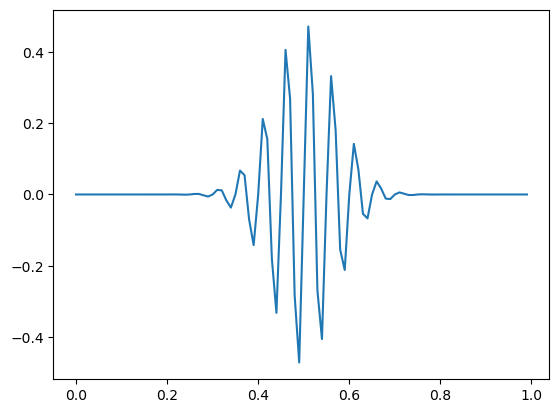

In [5]:
true_params = dict(
        A=0.5,
        t0=0.5,
        f0=20.,
        tau=1/10,
        ra=jnp.atleast_1d(0.5),
        dec=jnp.atleast_1d(0.5),
        psi=jnp.atleast_1d(0.5))

#simulate signal 
hp, hc = simulate_fd_sine_gaussian_waveform(true_params['A'], true_params['t0'], true_params['f0'], true_params['tau'], H1.times, f_min, H1.df)
hct = jnp.fft.irfft(hc)
pl.plot(H1.times,hct)

/home/dominika/.conda/envs/vigw/lib/python3.10/site-packages/jax/_src/array.py:341: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(self._value, dtype=dtype)


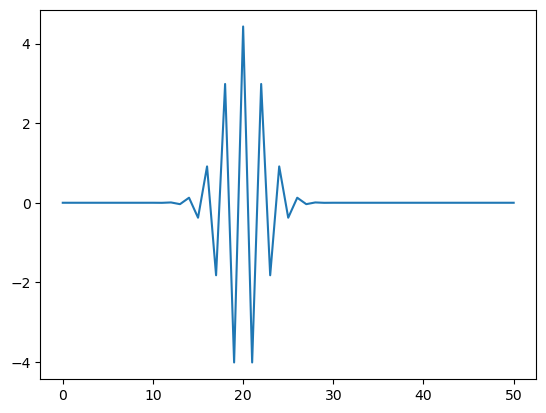

In [6]:
pl.plot(H1.freqs,hp)

In [7]:
H1_gw = get_H1()
H1_response = make_detector_response(H1_gw[0], H1_gw[1])   #detector_response(f, hp, hc, ra, dec, gmst, psi), strain in freq domain
#H1_response = make_detector_response(H1.tensor, H1.location)
L1_gw = get_L1()
L1_response = make_detector_response(L1_gw[0], L1_gw[1]) 
#L1_response = make_detector_response(L1.tensor, L1.location)   

gps = lal.LIGOTimeGPS(true_params['t0'])
gmst_rad = lal.GreenwichMeanSiderealTime(gps)

L1_signal = L1_response(L1.freqs, hp, hc, true_params['ra'], true_params['dec'], gmst_rad, true_params['psi'])   
H1_signal = H1_response(H1.freqs, hp, hc, true_params['ra'], true_params['dec'], gmst_rad, true_params['psi'])

#H1_noise = 0
#L1_noise = 0

#H1_noise = noise_fd_dict['H1'][freqs>fmin]
#H1_data = H1_noise + H1_signal

#L1_noise = noise_fd_dict['L1'][freqs>fmin]
#L1_data = L1_noise + L1_signal

response = {'H1': H1_response, 'L1': L1_response}

In [8]:
#from interferometer import Interferometer
from interferometer import Network
H1.signal=H1_signal
L1.signal=L1_signal
H1.psd=1.
L1.psd=1.
print(H1.get_signal_snr(),L1.get_signal_snr())
network = Network([H1,L1])
network.snr()

13.939145804194915 17.257479471123187


22.183786499307168

In [9]:
def project_to_detector(detector, hp, hc, ra, dec, gmst_rad, psi):                   
    """Compute the response of the detector to incoming strain """
    return response[detector](jnp.atleast_2d(H1.freqs), hp, hc, ra, dec, gmst_rad, psi)

In [10]:
test_params = dict(
        A = jnp.array([0.5,2.]),
        ra=jnp.array([0.5,1.]),
        dec=jnp.array([0.5,0.8]),
        psi=jnp.array([0.5,1.5]))

In [11]:
hp, hc = simulate_fd_sine_gaussian_waveform(jnp.atleast_2d(test_params['A']).T, true_params['t0'], true_params['f0'], true_params['tau'], jnp.atleast_2d(H1.times), f_min, H1.df)
#jnp.array([ self.simulate_response(hp, hc, params['ra'][i], params['dec'][i], params['psi'][i]) for i in range(len(params['ra']))])
#response['H1'](jnp.atleast_2d(H1_d.freqs), hp, hc, test_params['ra'], test_params['dec'], gmst_rad, test_params['psi'])

In [12]:
# likelihood function

class LogL(object):
    
    def __init__(self, true_gw_params):
        
        self.true_gw_params = true_gw_params
        self.detectors = {'H1': H1, 'L1': L1}
        
        gps_time = true_gw_params['t0']     #time of coalescence
        gps = lal.LIGOTimeGPS(gps_time)
        self.gmst_rad = lal.GreenwichMeanSiderealTime(gps)

        self.A = true_gw_params['A']
        self.t0 = true_gw_params['t0']
        self.f0 = true_gw_params['f0']
        self.tau = true_gw_params['tau']
        self.ra=jnp.atleast_1d(true_gw_params['ra'])
        self.dec = jnp.atleast_1d(true_gw_params['dec'])
        self.psi= jnp.atleast_1d(true_gw_params['psi'])

        self.f_min = 0.
        self.times = H1.times
        self.df = H1.df
        self.times2d = jnp.atleast_2d(H1.times)
        
        self.hp, self.hc = simulate_fd_sine_gaussian_waveform(self.A, self.t0, self.f0, self.tau, H1.times, self.f_min, H1.df)
        self.data = self.simulate_response(self.hp, self.hc, self.ra, self.dec, self.psi)
        

    #def simulate_response_matrix(self, hp, hc, ra, dec, psi):
        # r = {d: project_to_detector(d, hp, hc, ra, dec, self.gmst_rad, psi) for d in self.detectors.keys()}
        #print('before loop')
        #r = {d: jnp.array([project_to_detector(d, hp[i], hc[i], ra[i], dec[i], self.gmst_rad, psi[i]) for i in range(len(ra))]) for d in self.detectors.keys()}
        #print('after loop')
        #return r
    
    def simulate_response(self, hp, hc, ra, dec, psi):
        r = {d: project_to_detector(d, hp, hc, ra, dec, self.gmst_rad, psi) for d in self.detectors.keys()}
        return r
    
    def __call__(self, params):
        hp, hc = simulate_fd_sine_gaussian_waveform(jnp.atleast_2d(params['A']).T, self.t0, self.f0, self.tau, self.times2d, self.f_min, self.df)
        #hp, hc = simulate_fd_sine_gaussian_waveform(self.A, self.t0, self.f0, self.tau, self.times2d, self.f_min, self.df)
       
        r = self.simulate_response(hp, hc, params['ra'], params['dec'], params['psi'])

        residuals = jnp.array([r[ifo] - self.data[ifo] for ifo in self.detectors.keys()])
        
        return -jnp.real(jnp.sum(residuals*jnp.conj(residuals),axis=(0,2)))/2

    @property
    def params(self):
        params = ['A','ra','dec','psi']
        #params = ['ra','dec','psi']
        return params

    #@jax.jit
    def array_to_phys(self, x: Array) -> dict:
        
        p = dict()
        p['A'] = x[:,0]
        p['ra'] = x[:,1]*2*jnp.pi  #[0,2pi]
        p['dec'] = (x[:,2]-0.5)*jnp.pi  #[-pi/2,pi/2]
        p['psi'] = (x[:,3]-0.5)*jnp.pi #[-pi/2,pi/2]
        
        #p['ra'] = x[:,1]  #[0,2pi]
        #p['dec'] = x[:,2] #[-pi/2,pi/2]
        #p['psi'] = x[:,3] #[0,pi]

        return p

In [13]:
#Neural network setup

from vi_routines import make_flow_model

@hk.without_apply_rng
@hk.transform
def sample_and_log_prob(prng_key: PRNGKey, n: int) -> Tuple[Any, Array]:

    model = make_flow_model(                          #this is the flow distribution (a distrax object)
        event_shape=(n_params,),
        num_layers=flow_num_layers,
        hidden_sizes=[hidden_size] * mlp_num_layers,
        num_bins=num_bins
    )

    return model.sample_and_log_prob(seed=prng_key, sample_shape=(n,))
     # returns x (sample from the flow q), and model.log_prob(x) (array of log(q) of th sampled points)

@hk.without_apply_rng
@hk.transform
def log_prob_flow(sample: Array) -> Array:

    model = make_flow_model(                          #this is the flow distribution (a distrax object)
        event_shape=(n_params,),
        num_layers=flow_num_layers,
        hidden_sizes=[hidden_size] * mlp_num_layers,
        num_bins=num_bins
    )

    return model.log_prob(sample)
     # returns x (sample from the flow q), and model.log_prob(x) (array of log(q) of th sampled points)


def log_likelihood(x: Array) -> Array:      #transform to parameter space before c
    p = log_l.array_to_phys(x)
    return log_l(p) 

def log_prob(x: Array) -> Array:
    p = log_l.array_to_phys(x)
    return log_l(p) + jnp.log(jnp.cos(p['dec']))

def loss_fn(params: hk.Params, prng_key: PRNGKey, n: int) -> Array:       #computes reverse KL-divergence for the sample x_flow between the flow and gw loglikelihood.

    x_flow, log_q = sample_and_log_prob.apply(params, prng_key, n)           #gets sample from the flow and computes log_q for the sampled points.
    #log_p = log_likelihood(x_flow)
    log_p = log_prob(x_flow)
                                           #gets gw loglikelihood for the sampled points (after transforming them into physical space..)
    loss = jnp.mean(log_q - log_p)
    return loss

def loss_fn_mixed(params: hk.Params, prng_key: PRNGKey, n: int) -> Array:       #computes reverse KL-divergence for the sample x_flow between the flow and gw loglikelihood.

    x_flow, log_q = sample_and_log_prob.apply(params, prng_key, n)           #gets sample from the flow and computes log_q for the sampled points.
    log_p = log_likelihood(x_flow)
    log_p = log_prob(x_flow)            #gets gw loglikelihood for the sampled points (after transforming them into physical space..)

    m = 100
    x_uniform = jax.random.uniform(prng_key, shape=(m,4)) 
    log_p_uniform = log_prob(x_uniform)
    log_q_uniform = log_prob_flow.apply(params, x_uniform)
                                           
    loss = (n/(n+m))*jnp.mean(log_q - log_p) + (m/(n+m))*jnp.mean(jnp.exp(log_q_uniform)*(log_q_uniform-log_p_uniform))   #this needs log q added in the second part, otherwise it is just adding roughly same every time.
    return loss


@jax.jit
def update(
    params: hk.Params,
    prng_key: PRNGKey,
    opt_state: OptState,
) -> Tuple[hk.Params, OptState]:
    """Single SGD update step."""
    grads = jax.grad(loss_fn)(params, prng_key, Nsamps) #gradient w.r.t. params, evalueated at params, prng_key, Nsamps.
    updates, new_opt_state = optimiser.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state

In [14]:
n_params = 4
flow_num_layers = 4
hidden_size = 16
mlp_num_layers = 2
num_bins = 6


# perform variational inference
epochs = 9000
Nsamps = 1000


In [15]:

learning_rate = 0.01
optimiser = optax.adam(learning_rate)              #stochastic gradient descent 

prng_seq = hk.PRNGSequence(42)
key = next(prng_seq)
params = sample_and_log_prob.init(key, prng_key=key, n=Nsamps)
opt_state = optimiser.init(params)

from tqdm import tqdm, trange
   
ldict = dict(loss = [])
training_stats = dict(loss = [], mean_loss = np.inf, fixed_flow_loss_variance=[], loss_variance=[])

log_l = LogL(true_params)         


In [16]:
log_l(true_params)

Array([-0.], dtype=float64)

In [17]:
truths=[0.5,0.5,0.5,0.5]


  0%|          | 0/9000 [00:00<?, ?it/s, loss=9.19]

Epoch 0, loss 9.187718732300212


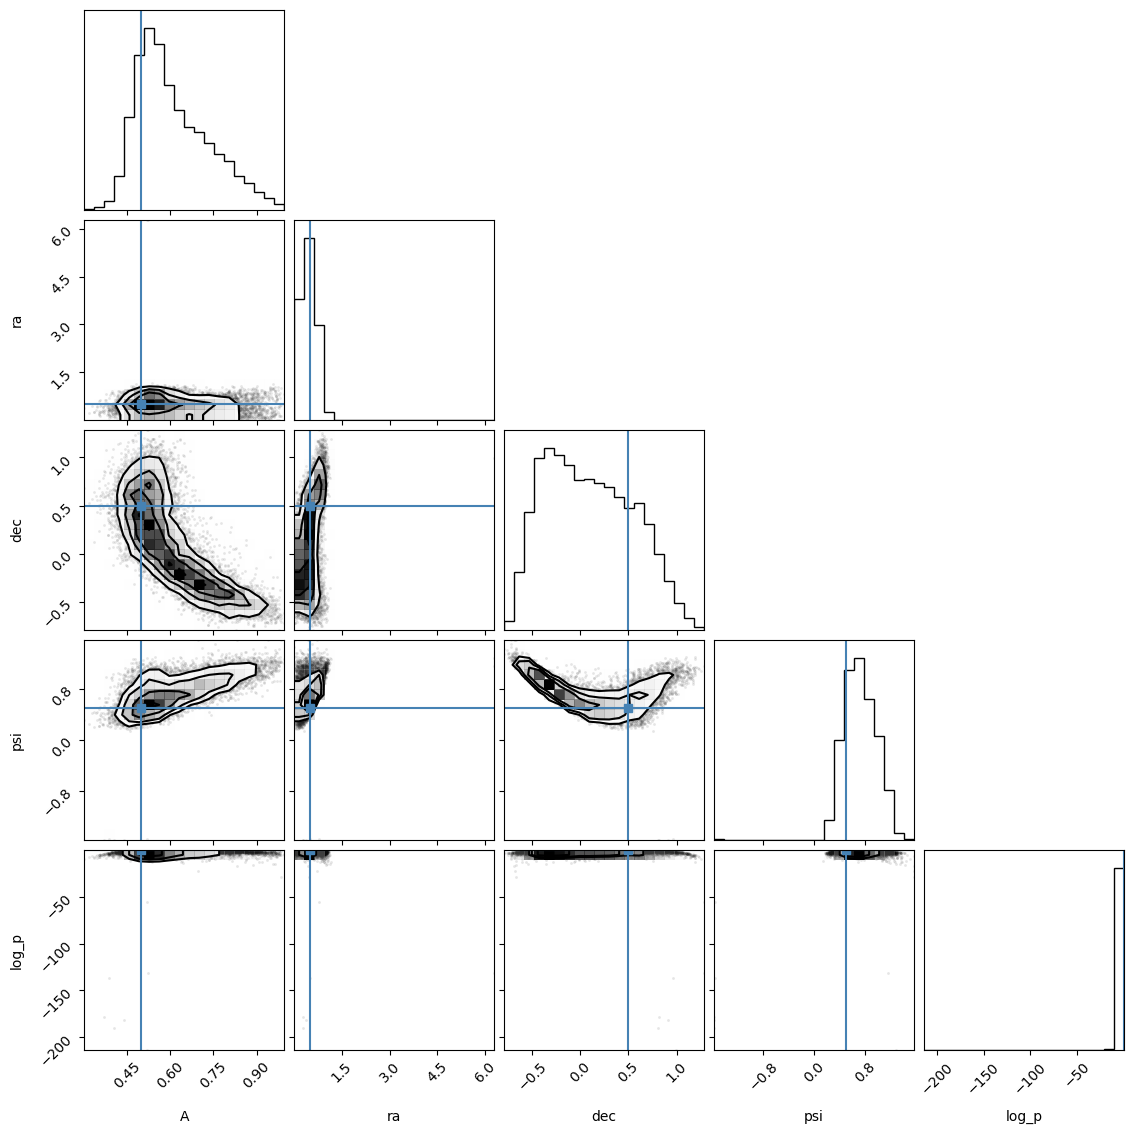

  1%|          | 100/9000 [00:40<56:09,  2.64it/s, loss=8.98] 

Epoch 100, loss 8.975451093748198


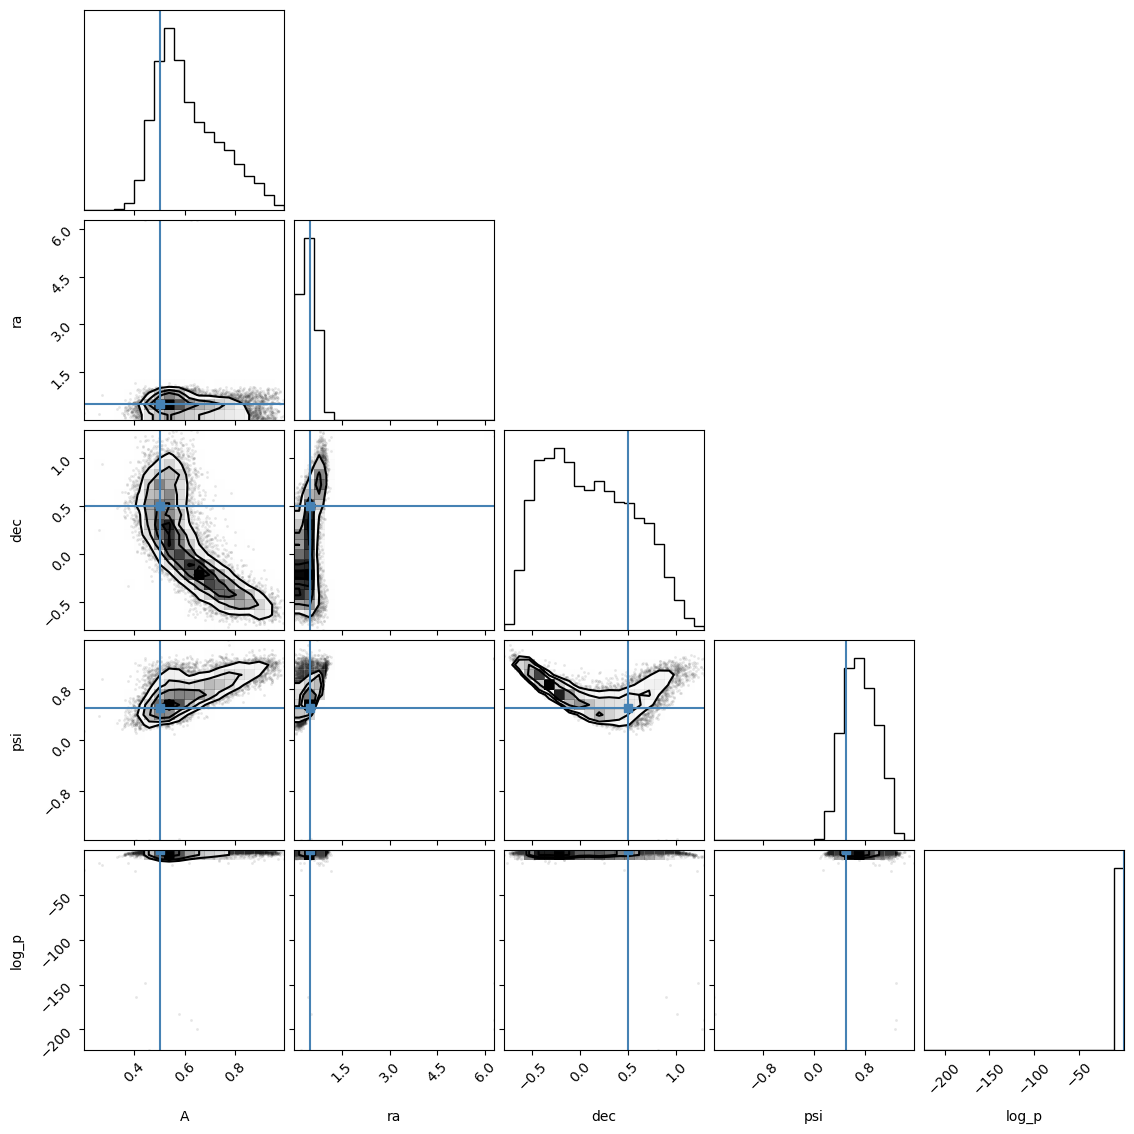

  2%|▏         | 200/9000 [01:18<52:29,  2.79it/s, loss=8.95]  

Epoch 200, loss 8.949526033445606


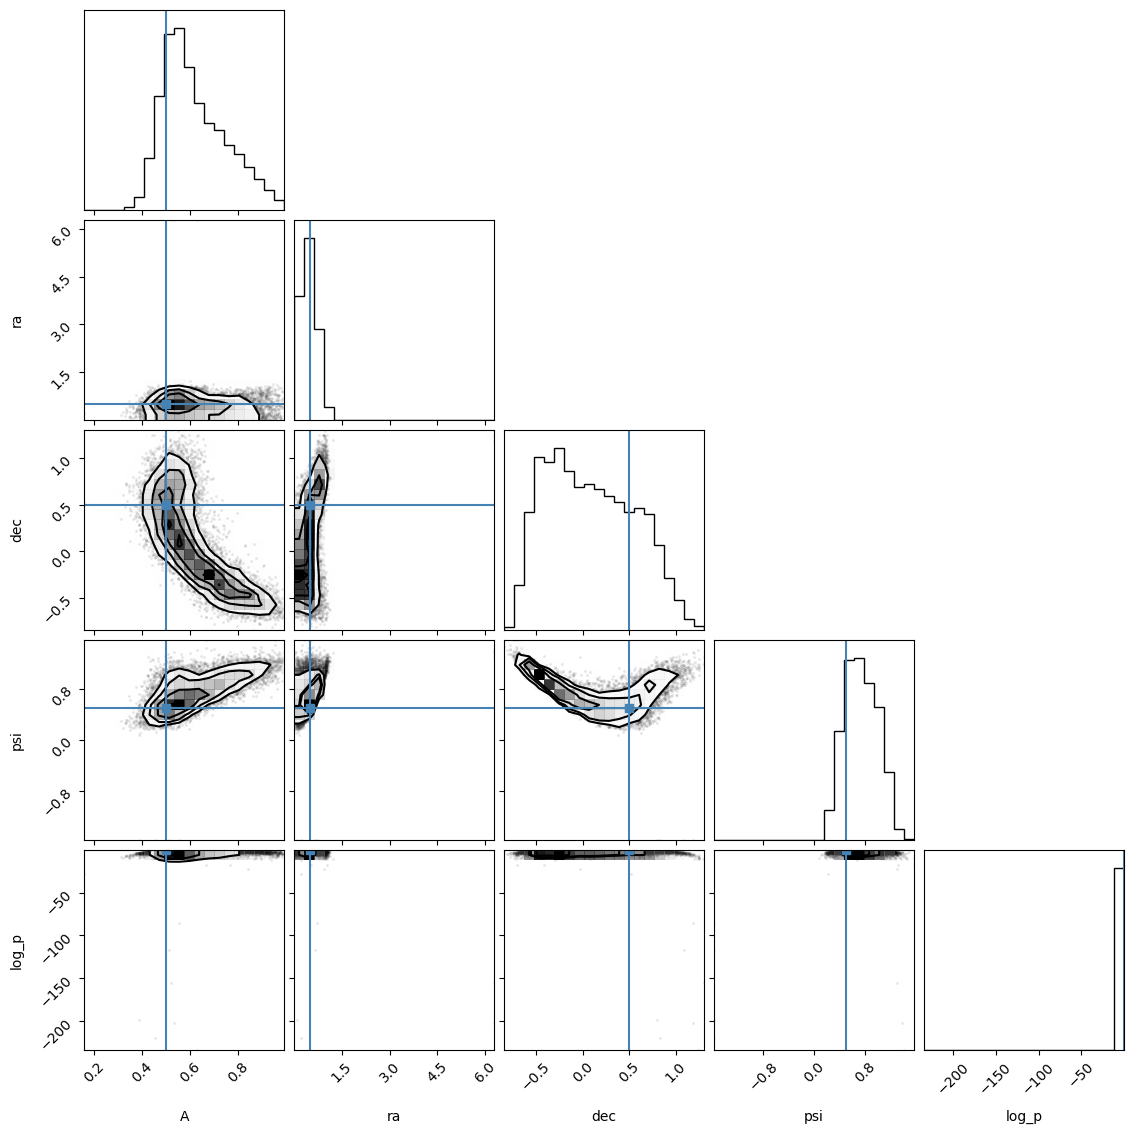

  3%|▎         | 300/9000 [01:56<52:04,  2.78it/s, loss=8.97]  

Epoch 300, loss 8.972022595816554


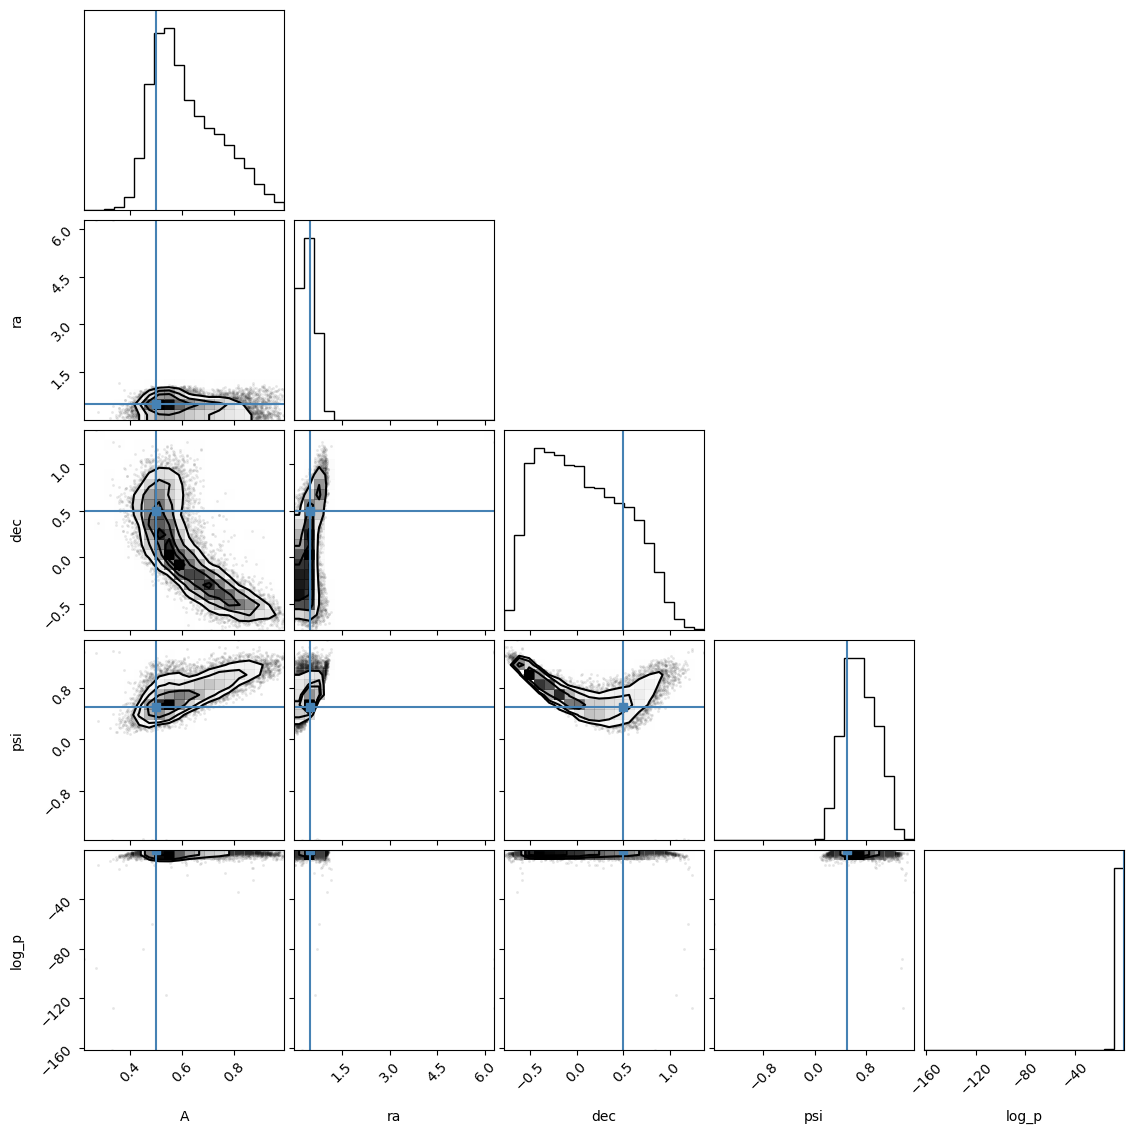

  4%|▍         | 400/9000 [02:34<53:10,  2.70it/s, loss=9.06]  

Epoch 400, loss 9.058247068842567


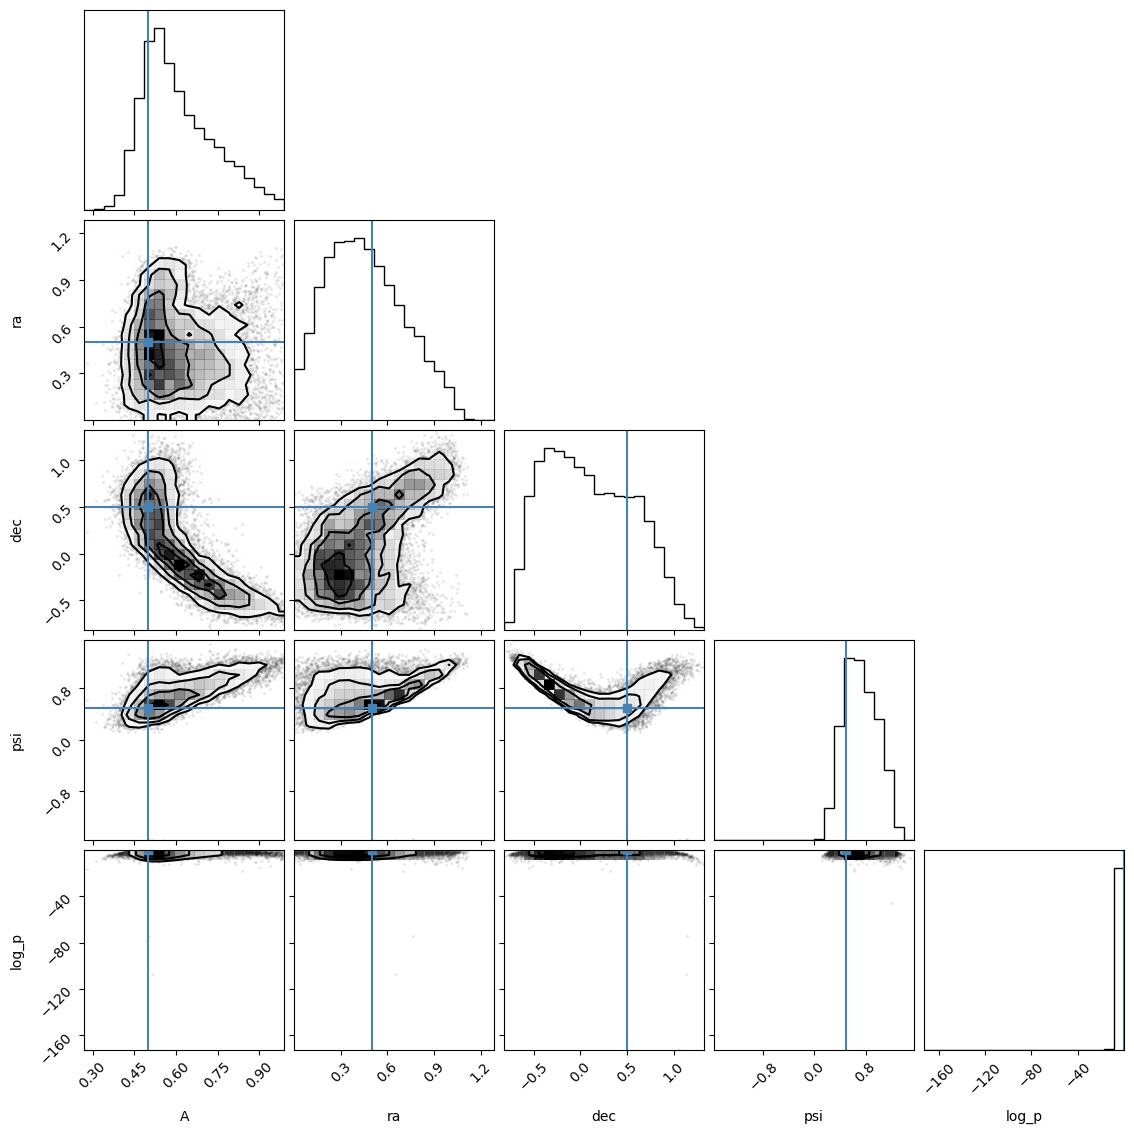

  6%|▌         | 500/9000 [03:13<56:02,  2.53it/s, loss=9.15]  

Epoch 500, loss 9.149475313825489


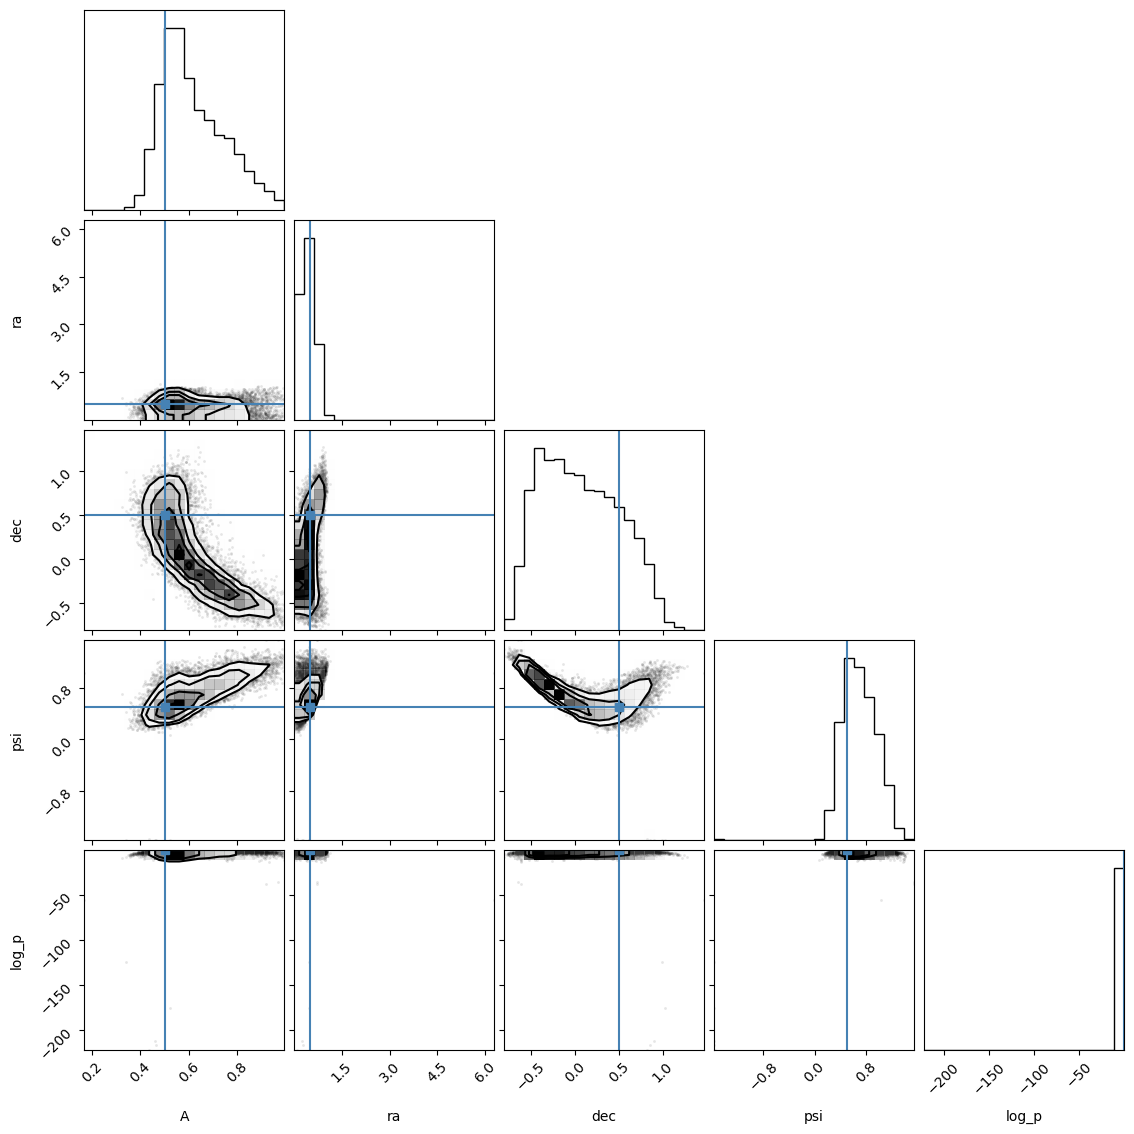

  7%|▋         | 600/9000 [03:51<51:20,  2.73it/s, loss=8.94]  

Epoch 600, loss 8.942892194069682


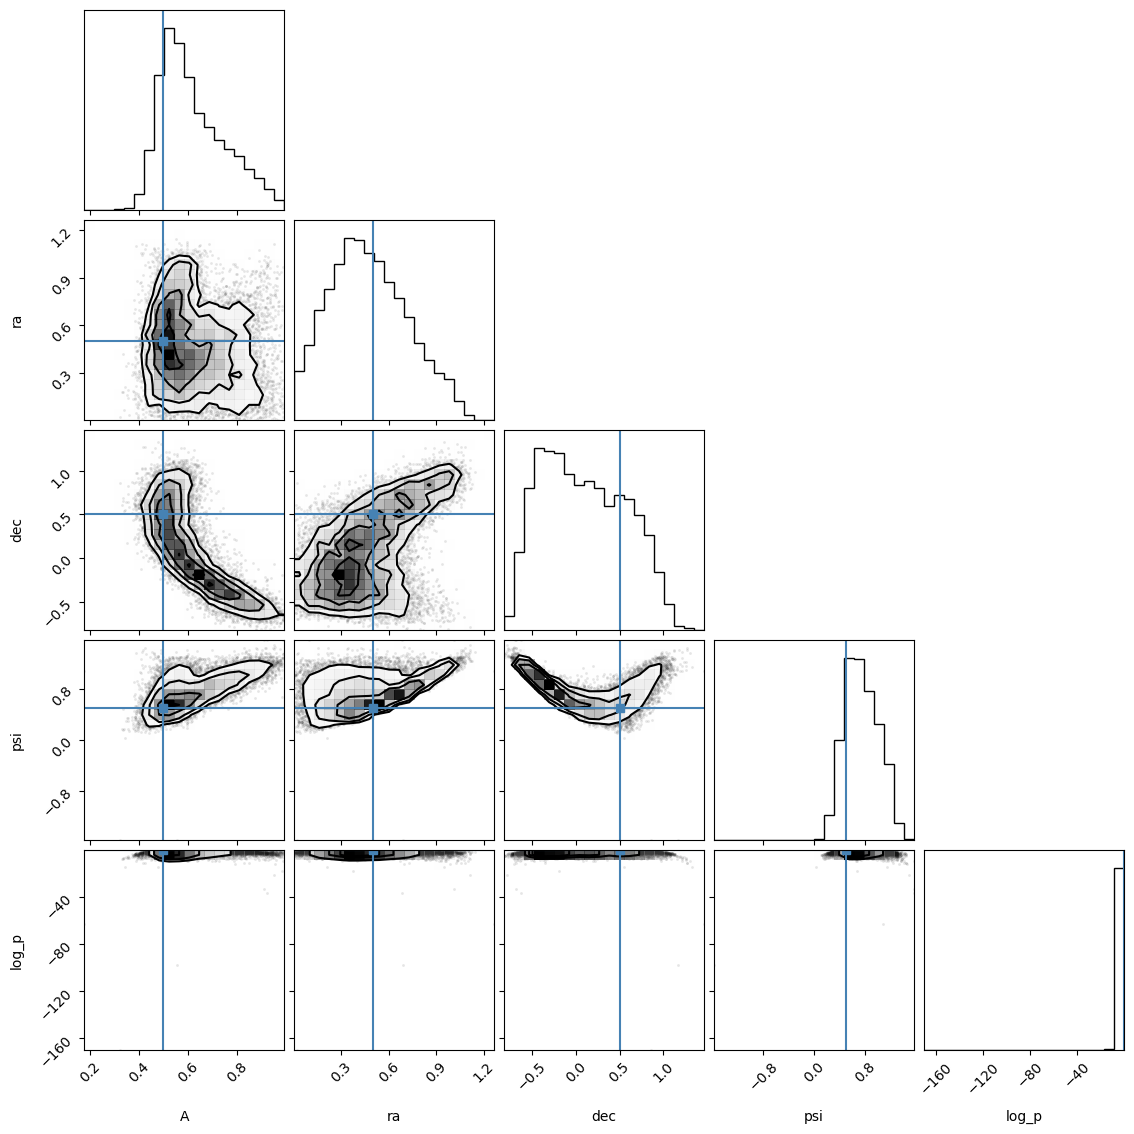

  8%|▊         | 700/9000 [04:29<52:41,  2.63it/s, loss=8.95]  

Epoch 700, loss 8.946601590687385


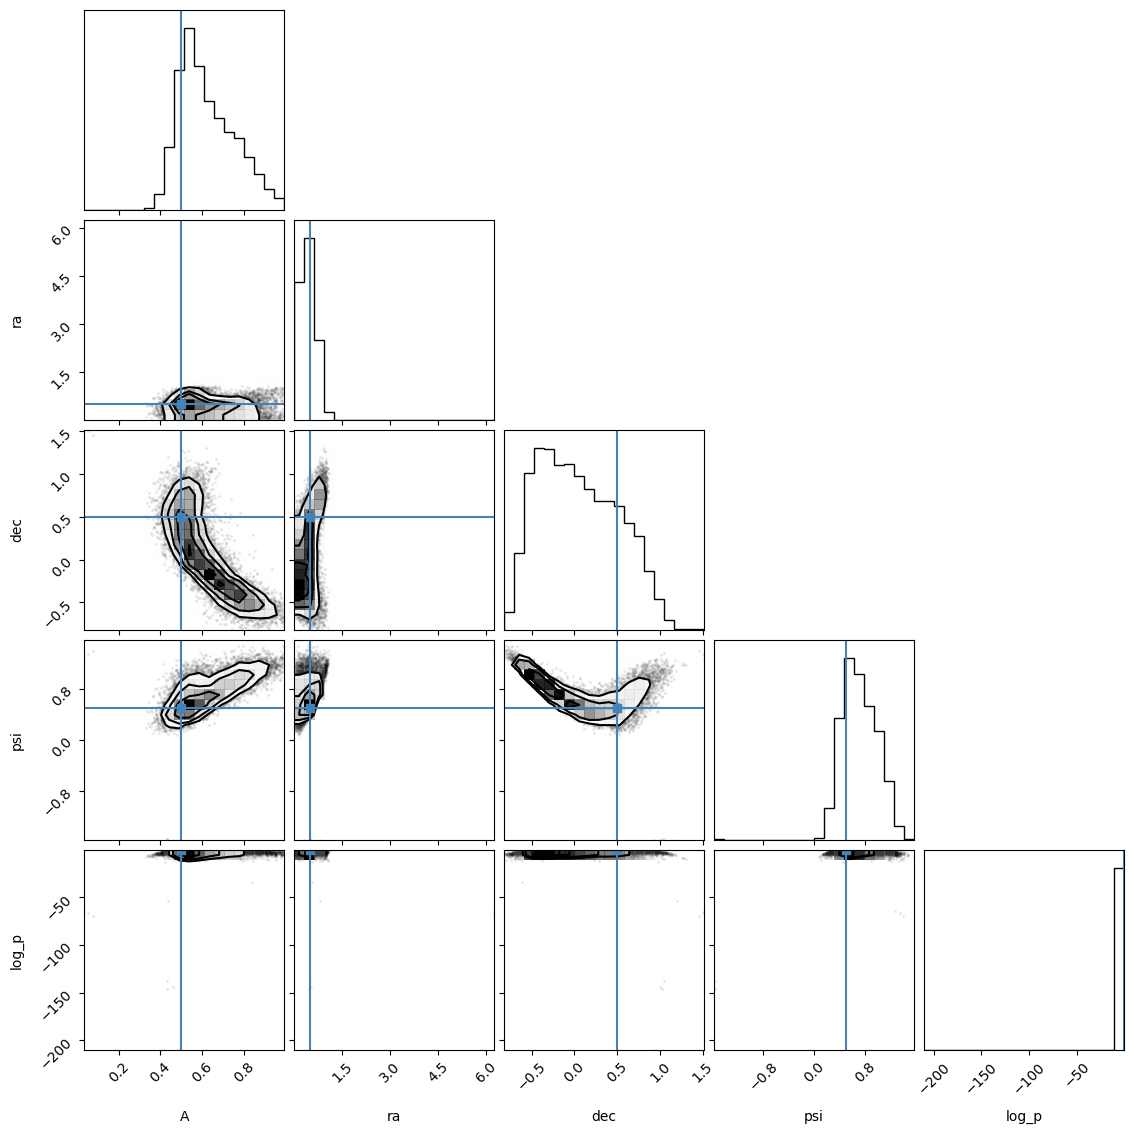

  9%|▉         | 800/9000 [05:07<49:11,  2.78it/s, loss=9.05]  

Epoch 800, loss 9.047158985255795


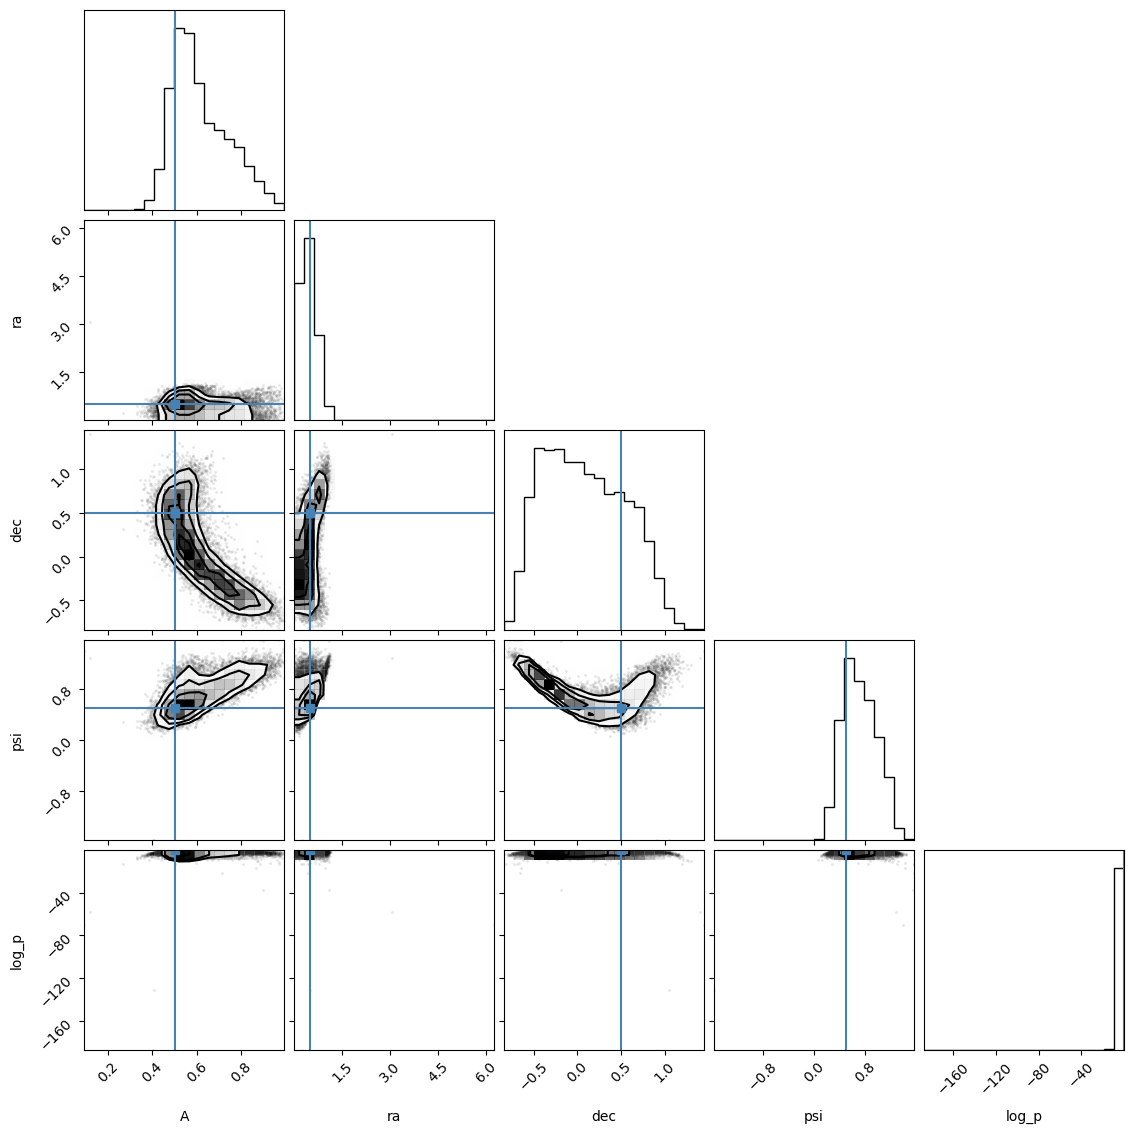

 10%|█         | 900/9000 [05:45<48:08,  2.80it/s, loss=8.95]  

Epoch 900, loss 8.954970297289234


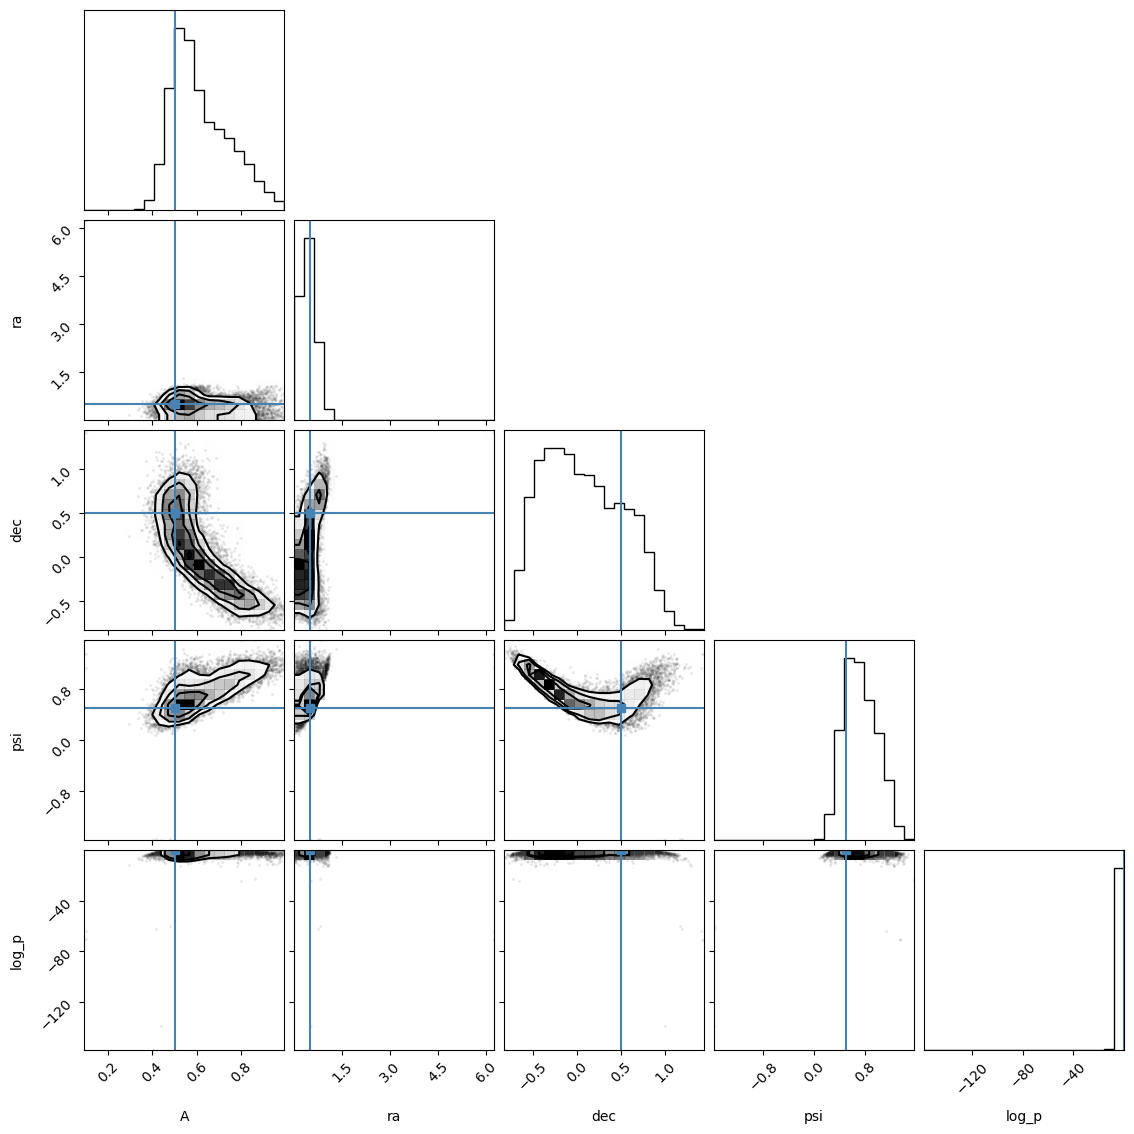

 11%|█         | 1000/9000 [08:56<103:16:47, 46.48s/it, loss=8.96]

fixed_flow_loss_variance 0.009547805365375027


 11%|█         | 1000/9000 [08:56<103:16:47, 46.48s/it, loss=9.07]

Epoch 1000, loss 9.071090844283377


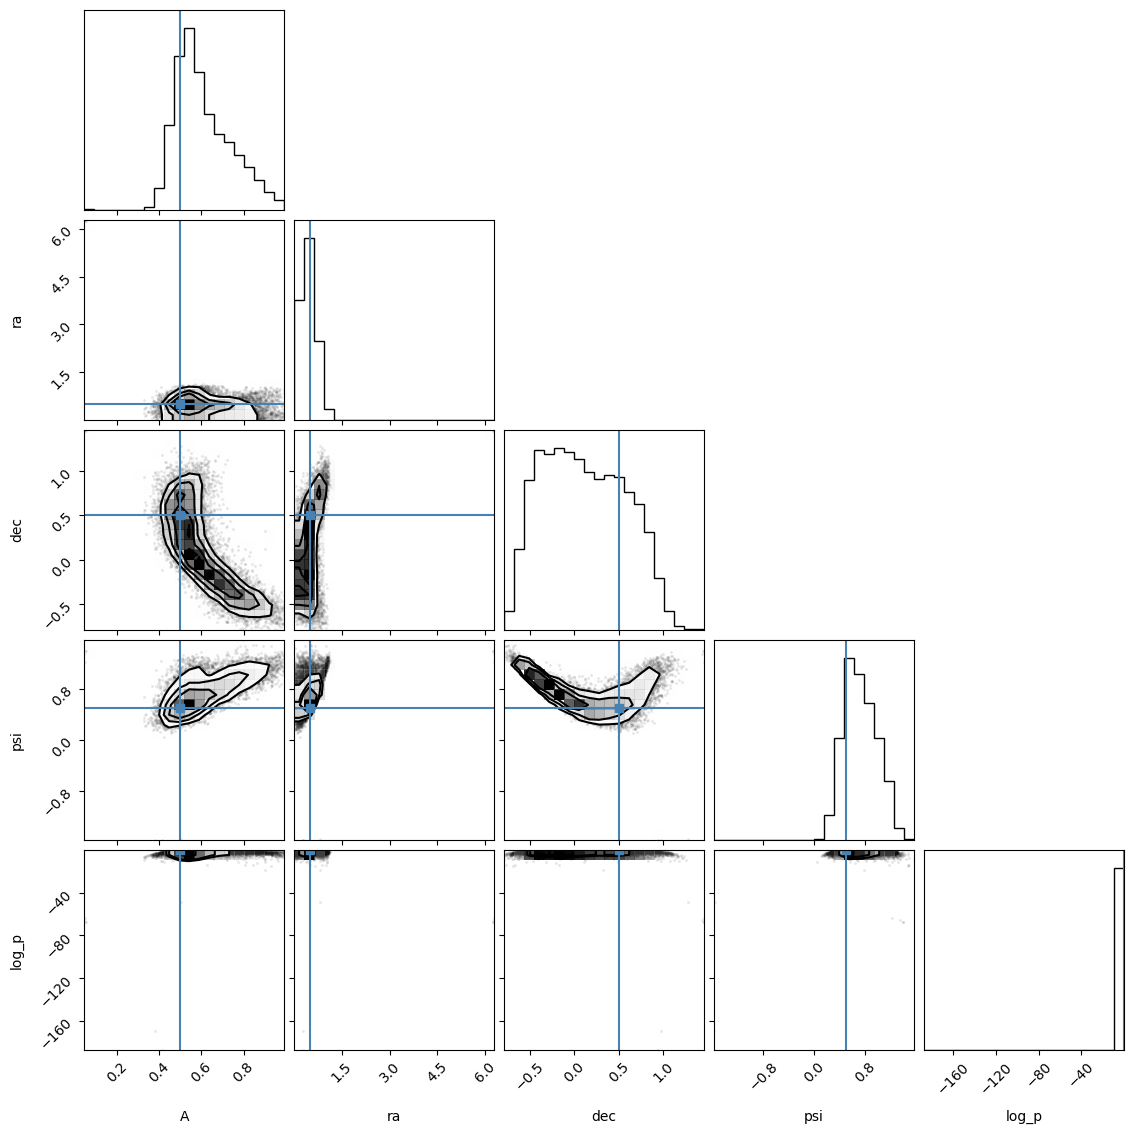

 12%|█▏        | 1100/9000 [09:33<46:30,  2.83it/s, loss=8.92]    

Epoch 1100, loss 8.92113917141989


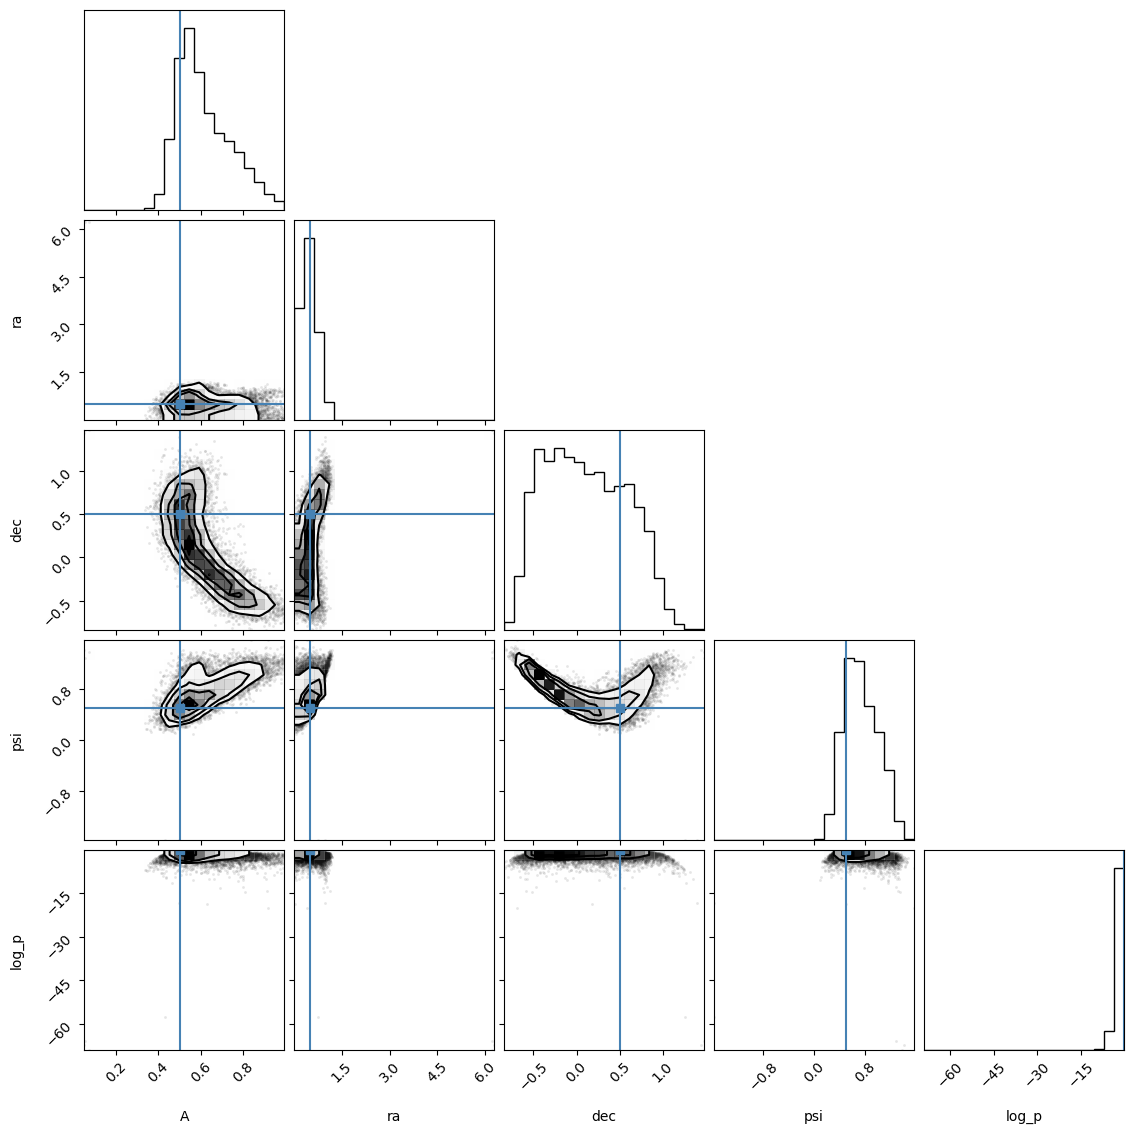

 13%|█▎        | 1200/9000 [10:10<45:24,  2.86it/s, loss=9.25]  

Epoch 1200, loss 9.248758607064858


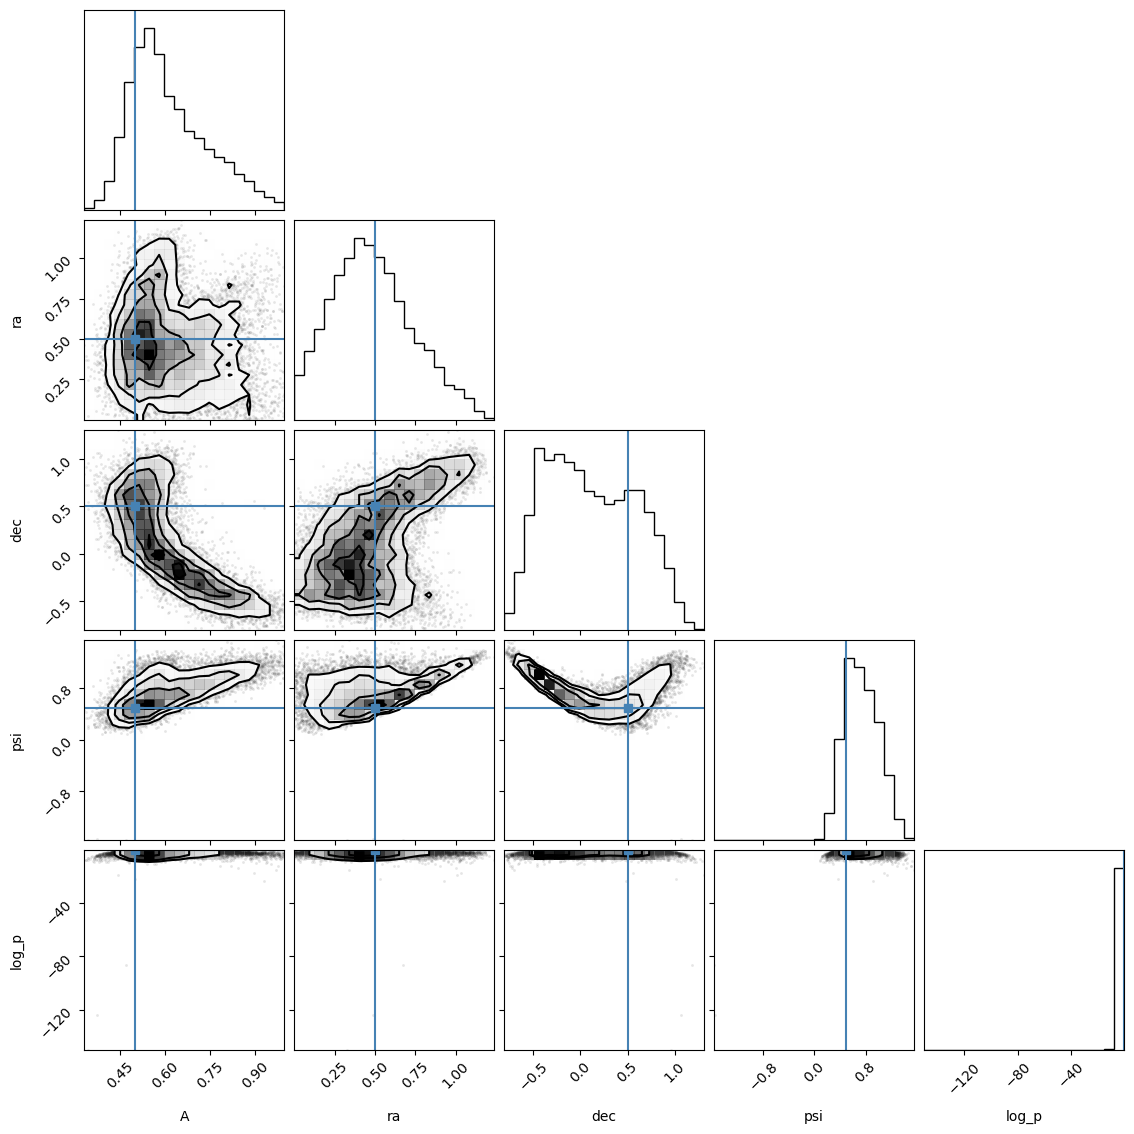

 14%|█▍        | 1300/9000 [10:48<47:42,  2.69it/s, loss=8.91]  

Epoch 1300, loss 8.905067974795076


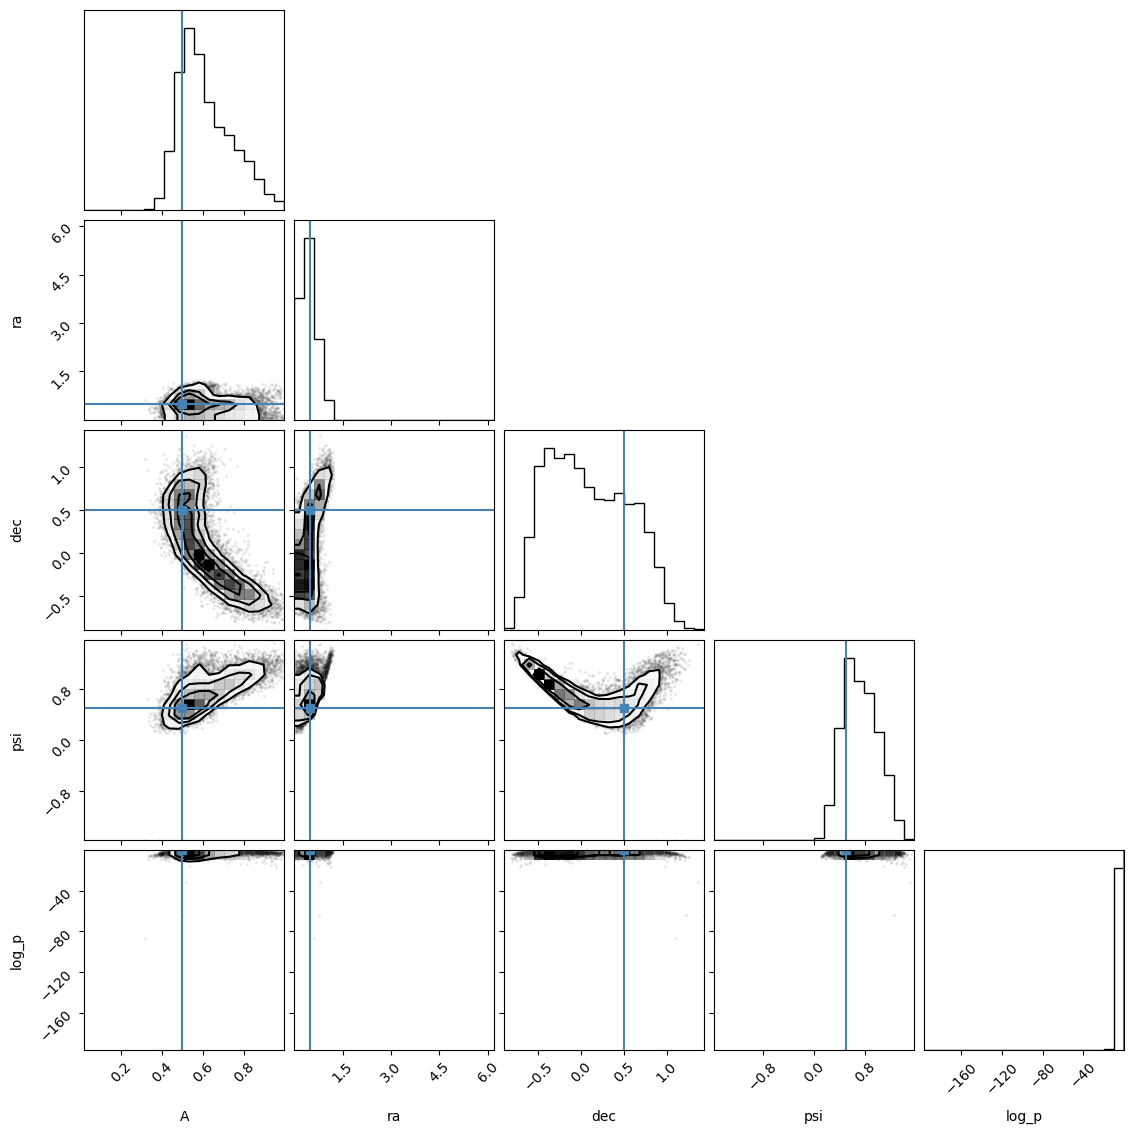

 16%|█▌        | 1400/9000 [11:25<45:17,  2.80it/s, loss=8.95]  

Epoch 1400, loss 8.952887129039423


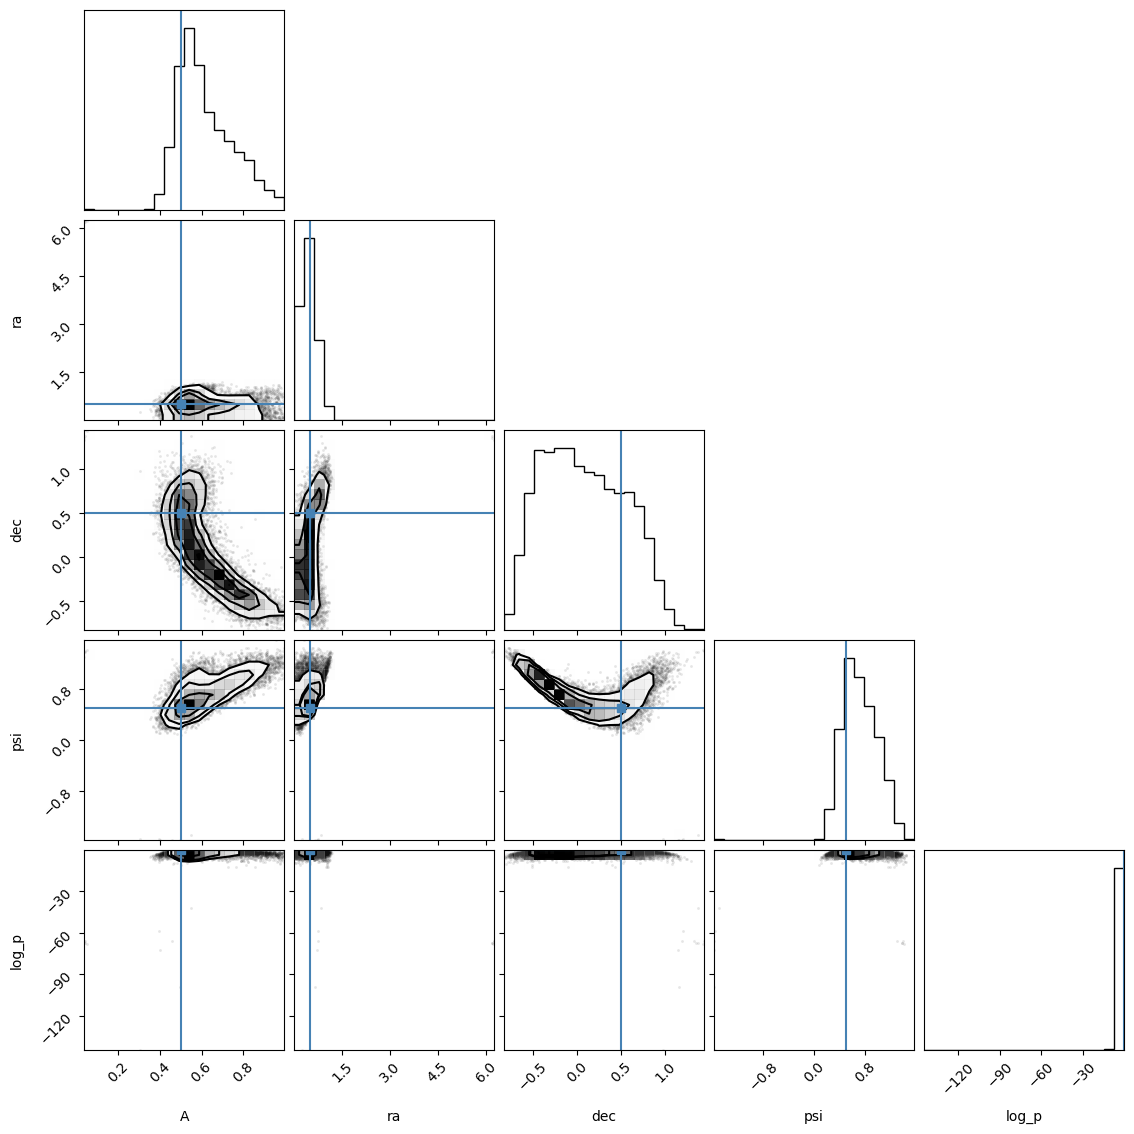

 17%|█▋        | 1500/9000 [12:03<45:16,  2.76it/s, loss=8.93]  

Epoch 1500, loss 8.931073307741766


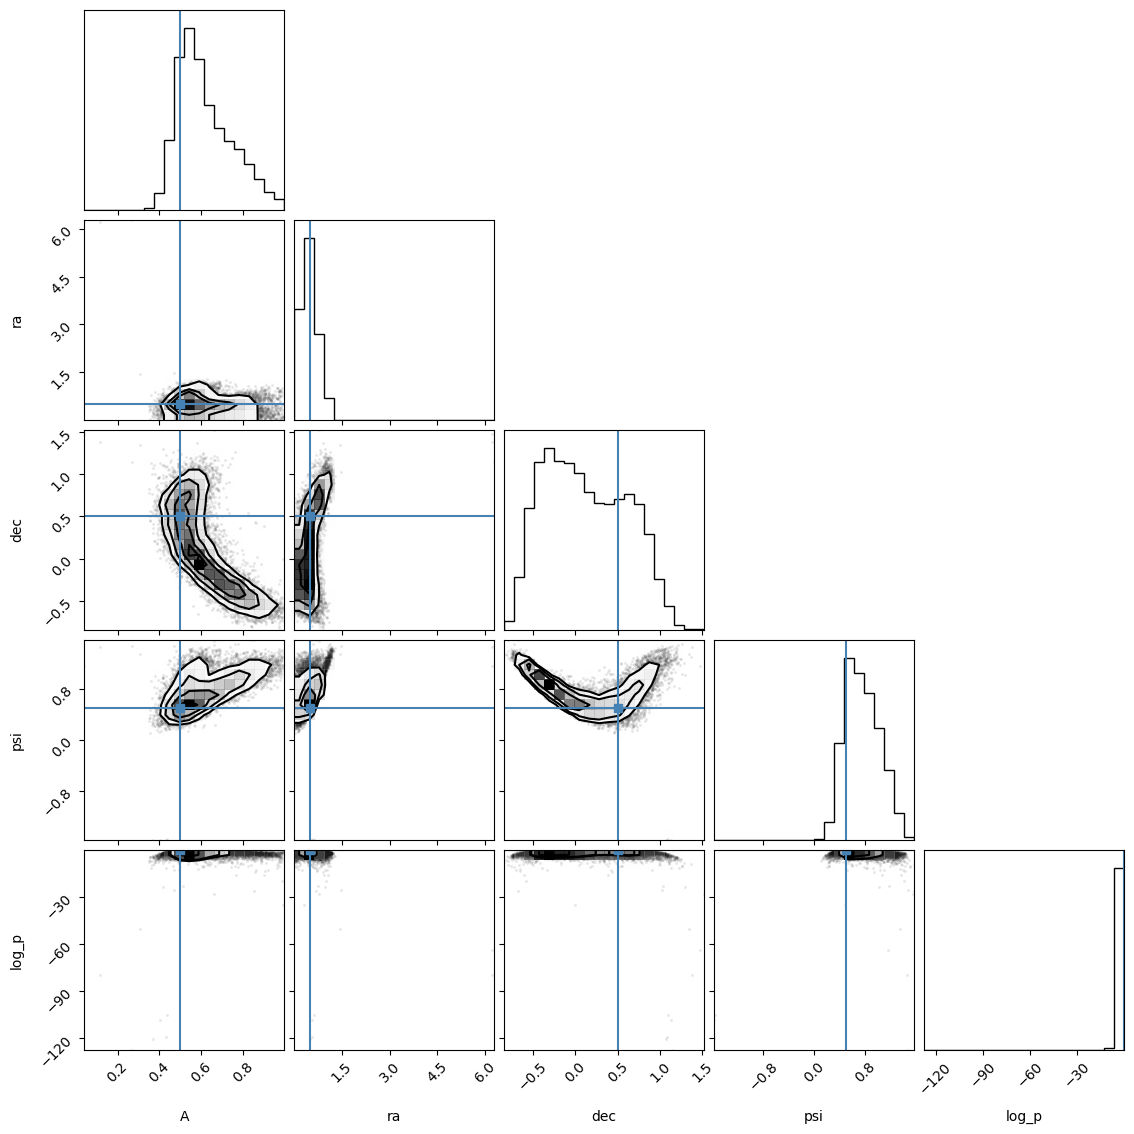

 18%|█▊        | 1600/9000 [12:40<44:06,  2.80it/s, loss=8.90]  

Epoch 1600, loss 8.904543165054015


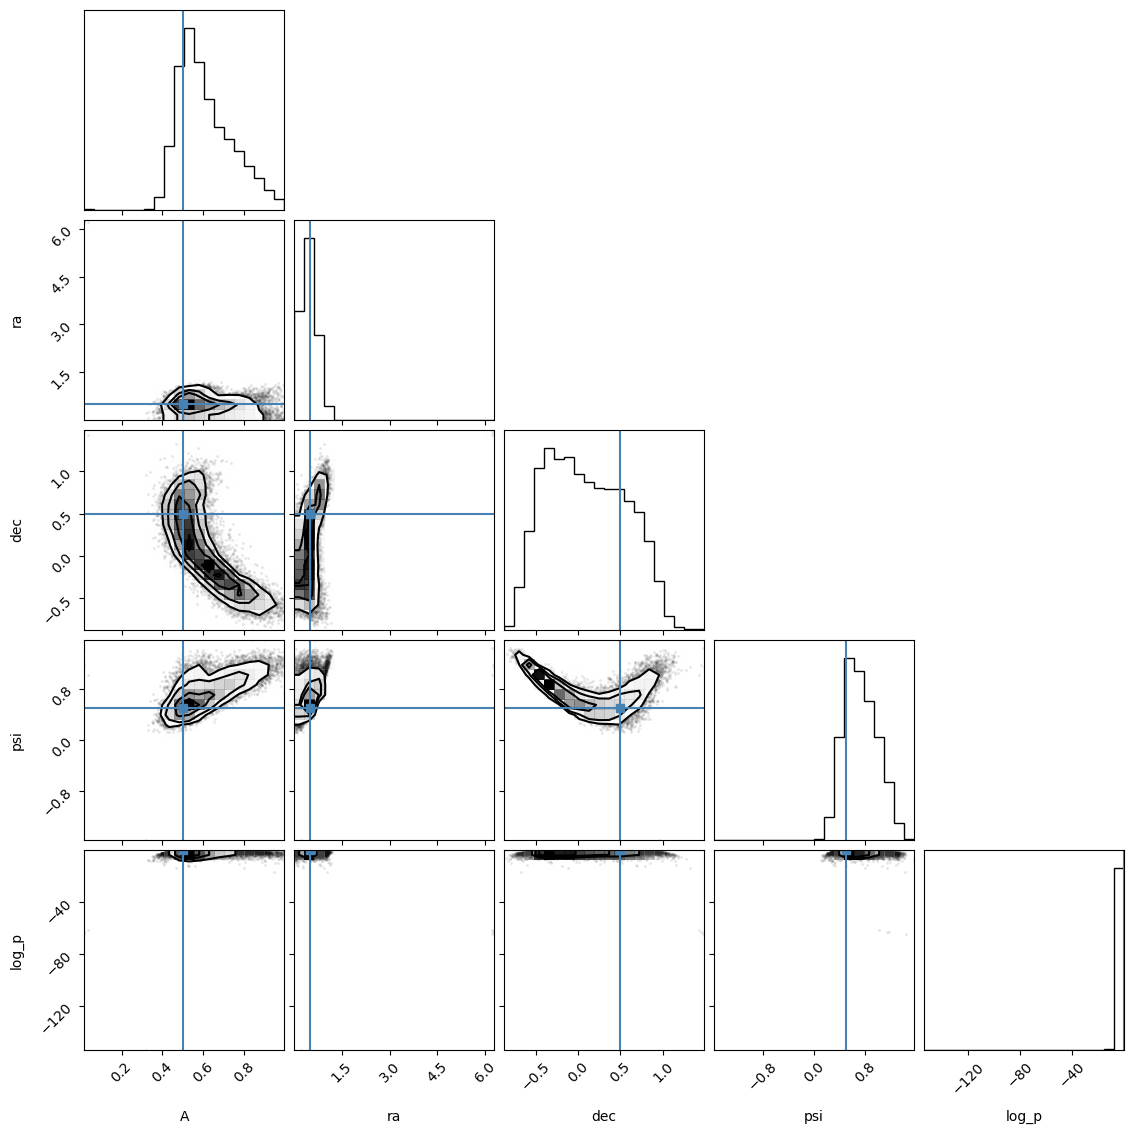

 19%|█▉        | 1700/9000 [13:18<42:47,  2.84it/s, loss=8.92]  

Epoch 1700, loss 8.92124986042067


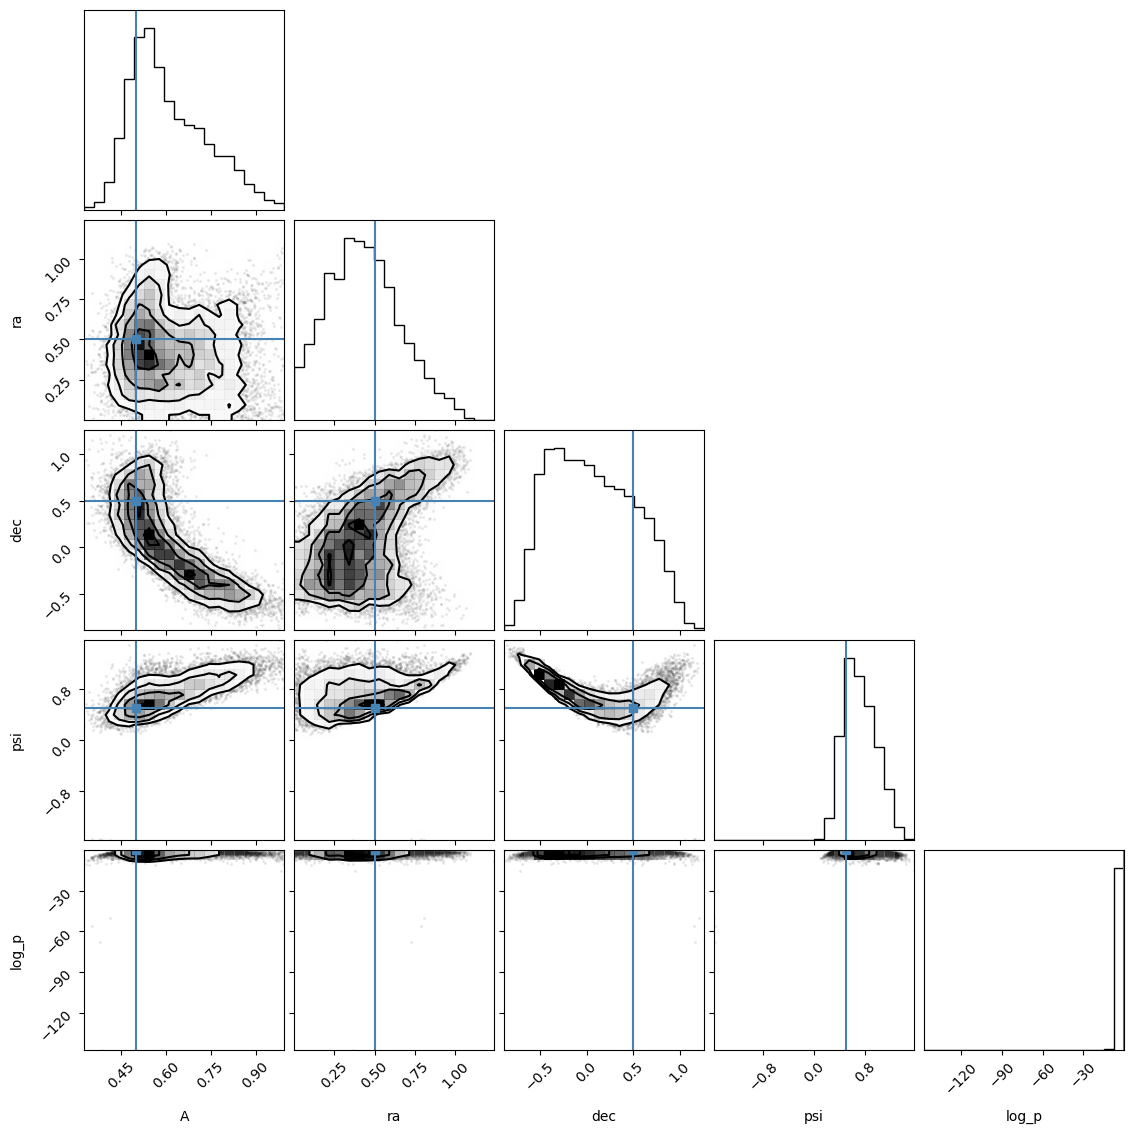

 20%|██        | 1800/9000 [13:56<43:03,  2.79it/s, loss=8.99]  

Epoch 1800, loss 8.988313354015546


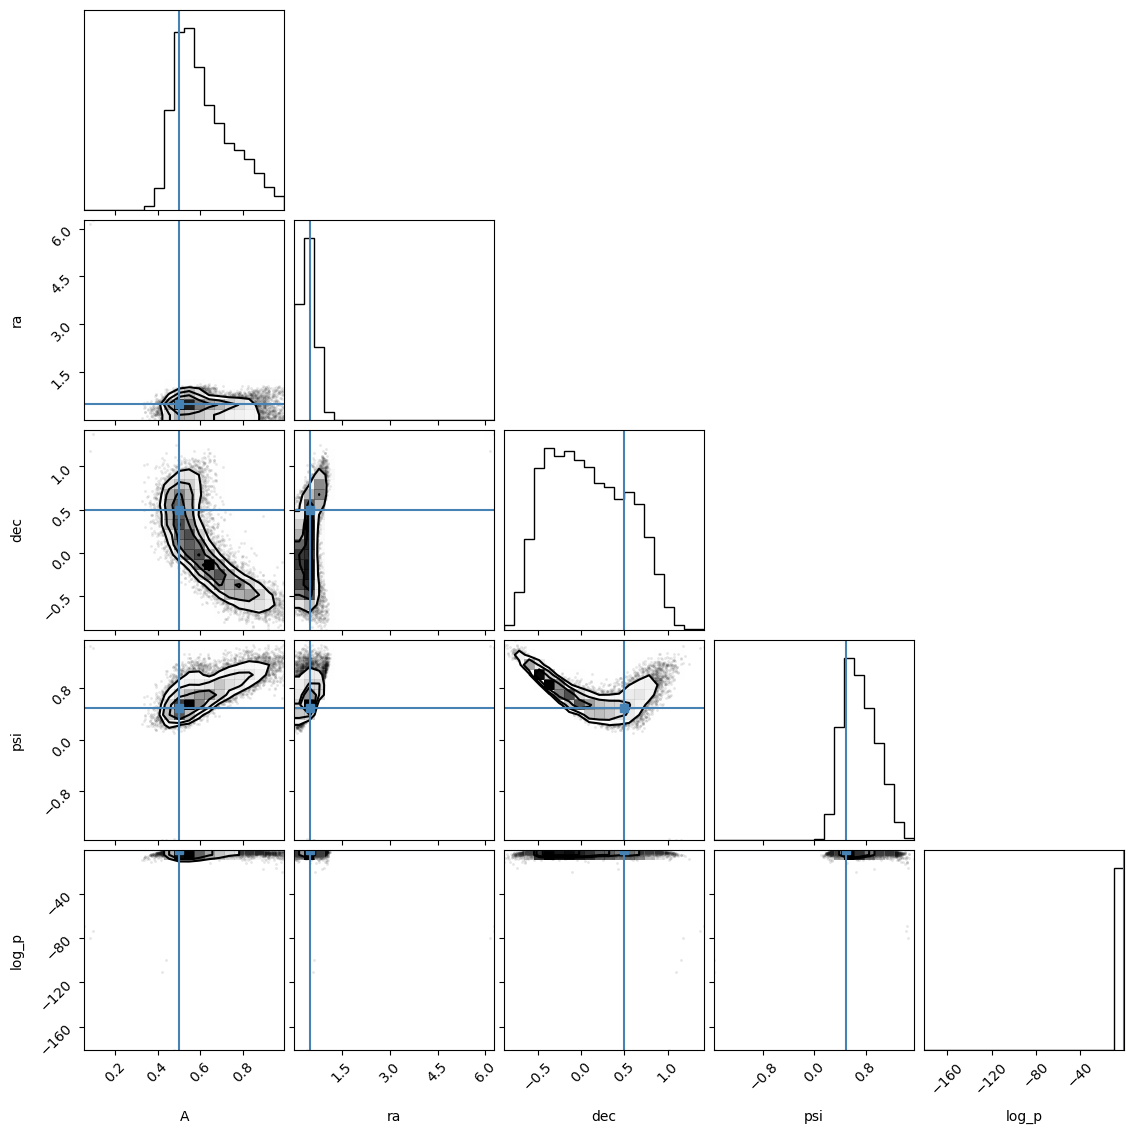

 21%|██        | 1900/9000 [14:33<41:29,  2.85it/s, loss=9.13]  

Epoch 1900, loss 9.130959734541127


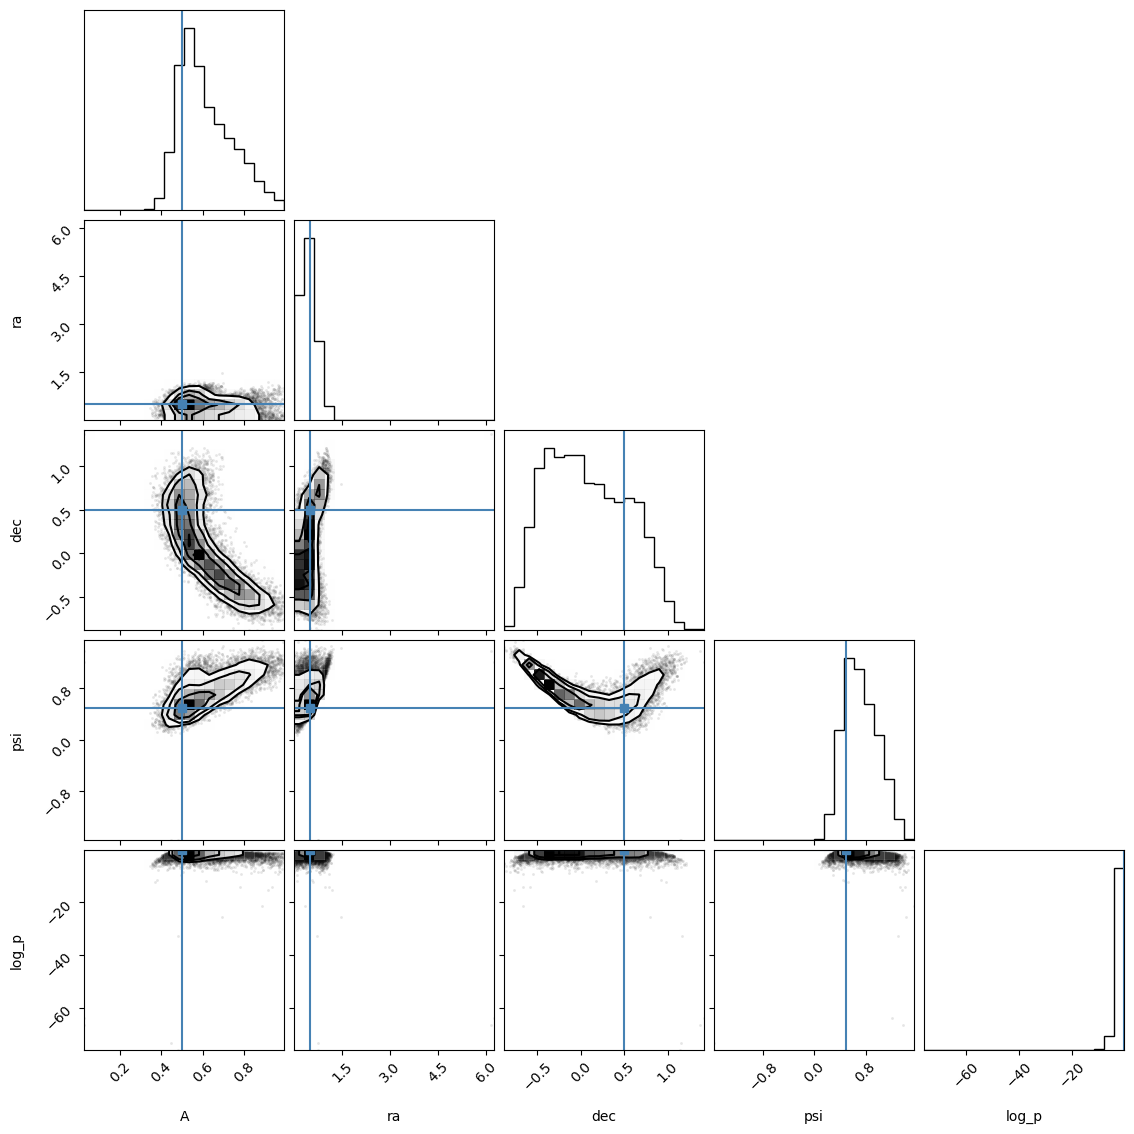

 22%|██▏       | 2000/9000 [17:41<89:17:16, 45.92s/it, loss=9.00]

fixed_flow_loss_variance 0.005766109249480487


 22%|██▏       | 2000/9000 [17:42<89:17:16, 45.92s/it, loss=8.93]

Epoch 2000, loss 8.933305965339681


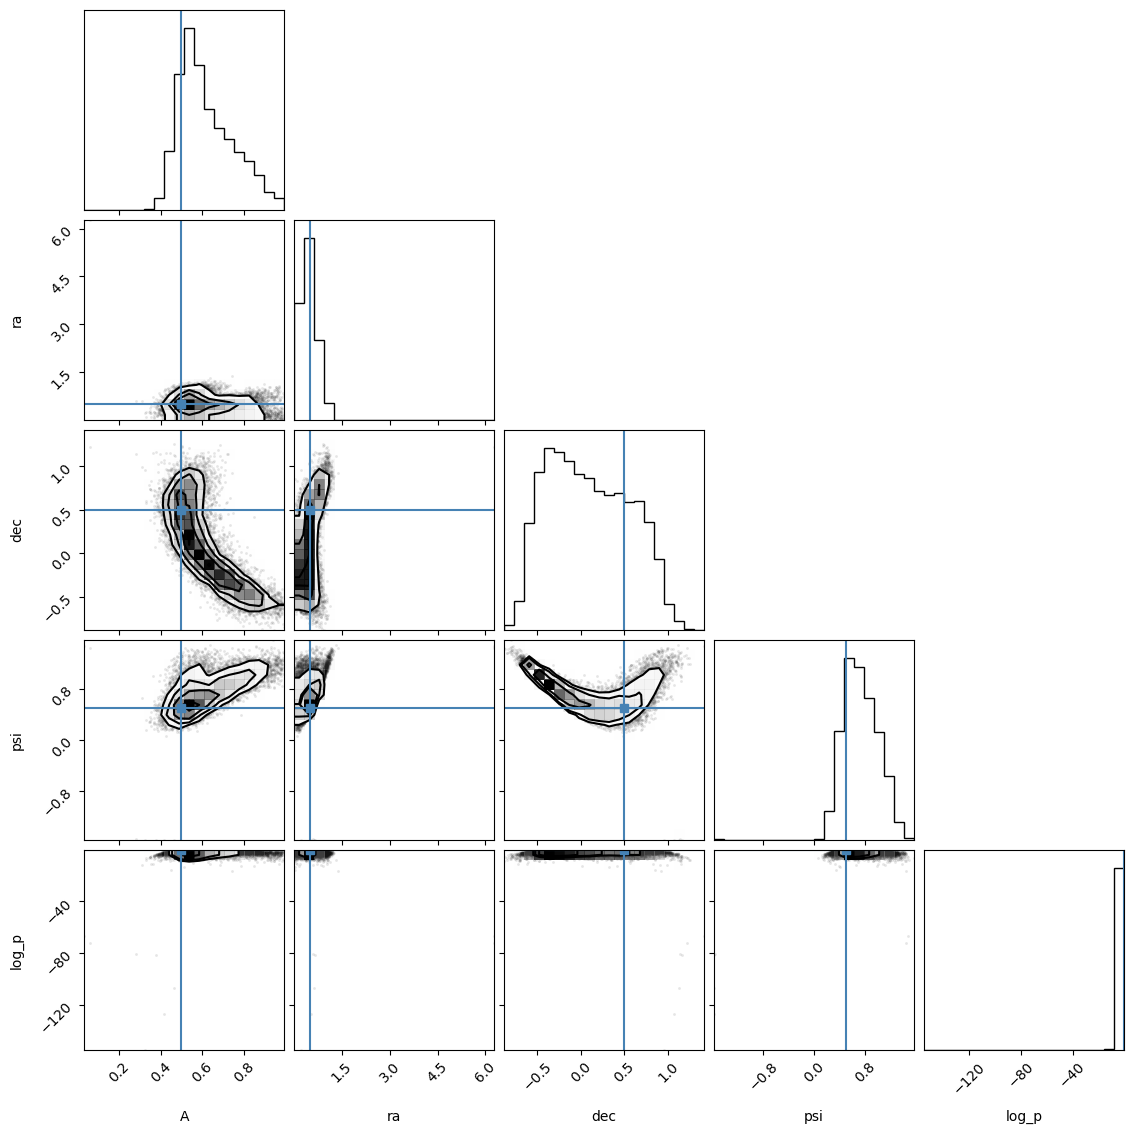

 23%|██▎       | 2100/9000 [18:19<40:18,  2.85it/s, loss=9.07]   

Epoch 2100, loss 9.07351761773444


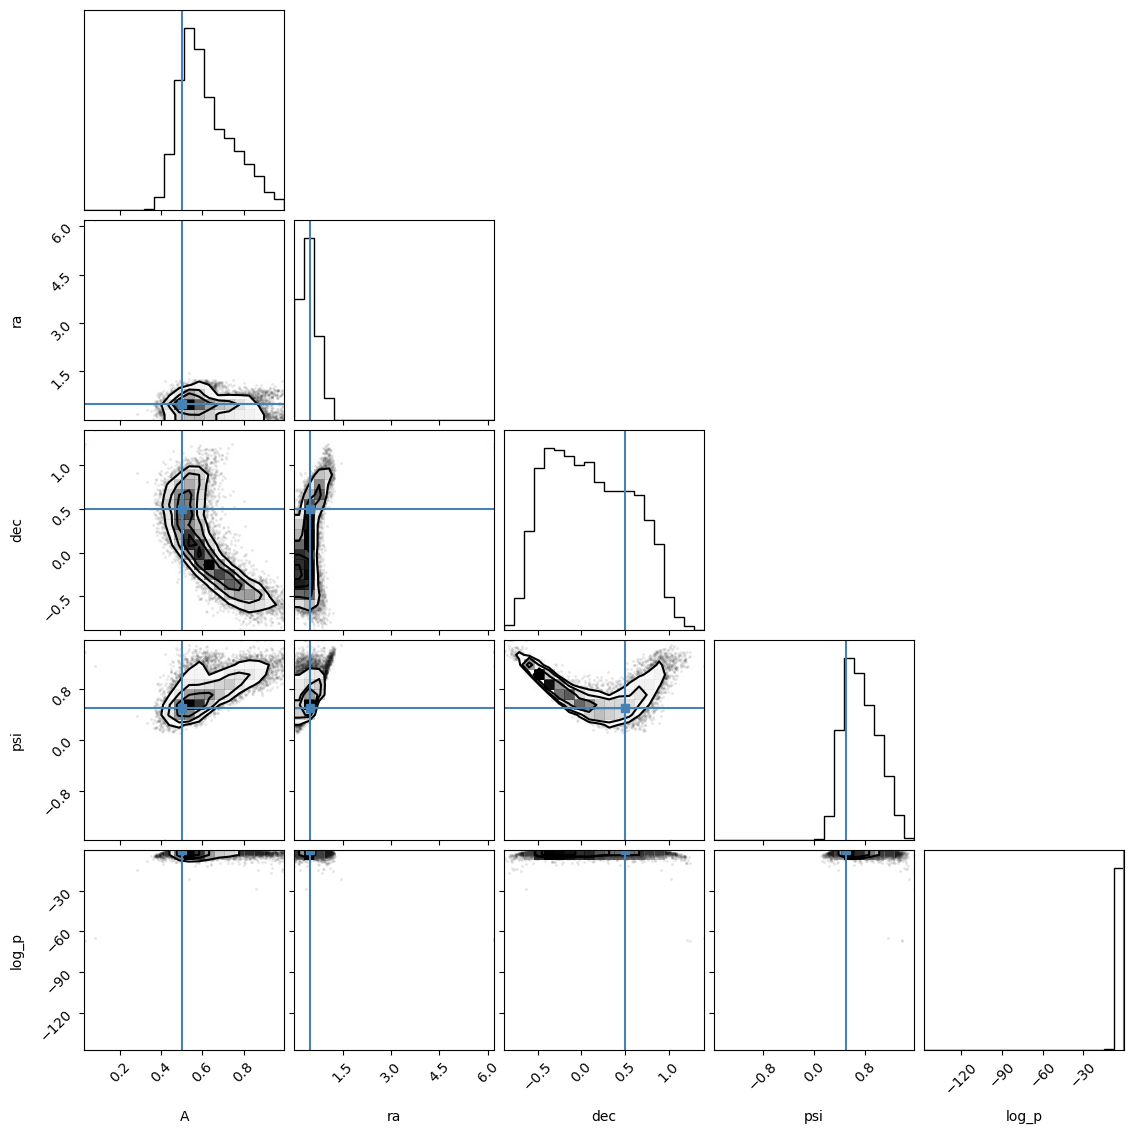

 24%|██▍       | 2200/9000 [18:56<39:42,  2.85it/s, loss=8.96]  

Epoch 2200, loss 8.960241221603457


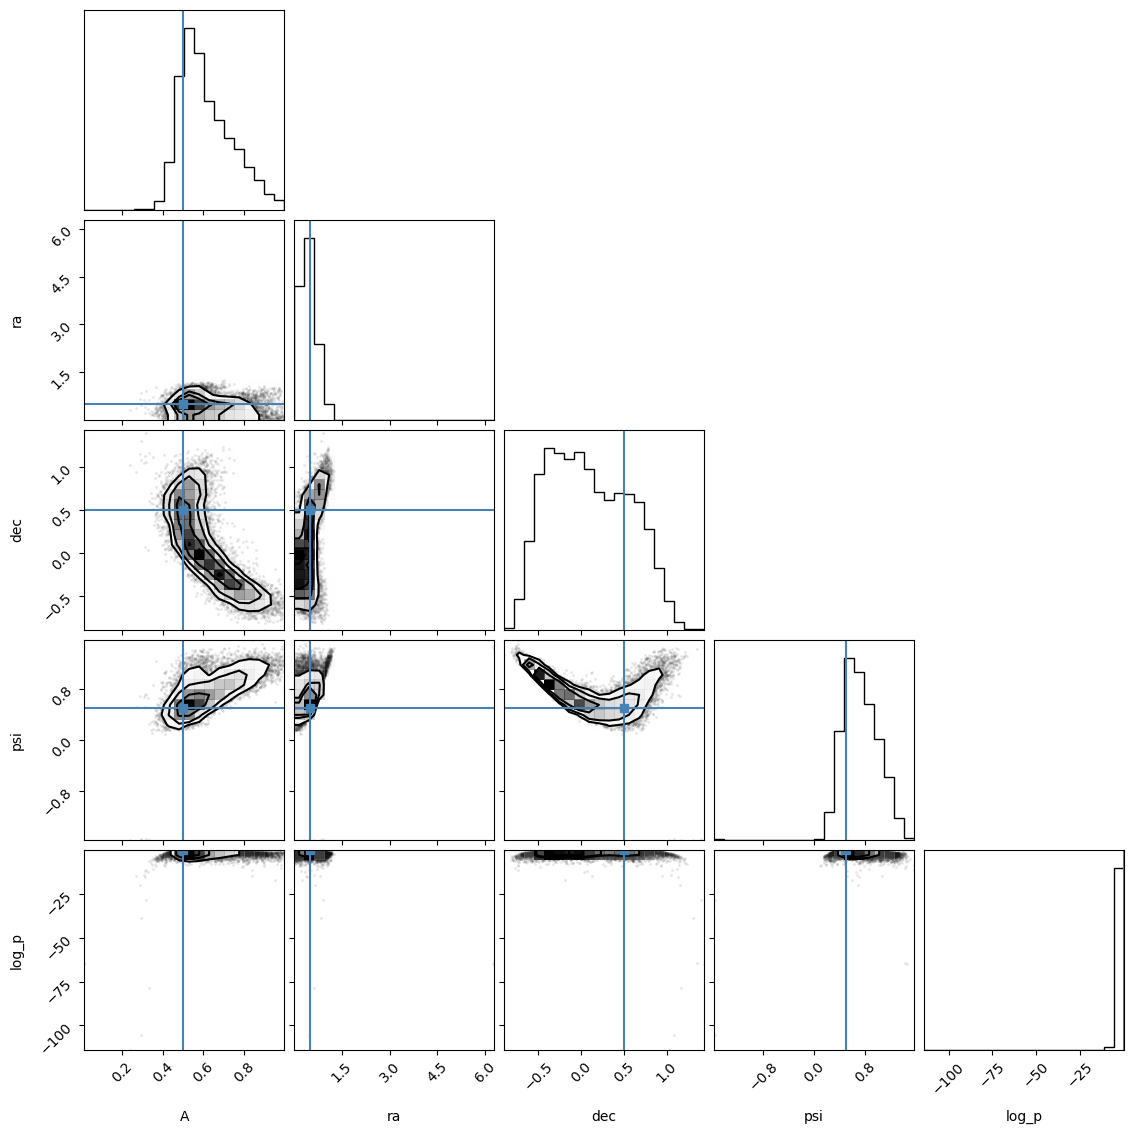

 26%|██▌       | 2300/9000 [19:33<39:19,  2.84it/s, loss=8.91]  

Epoch 2300, loss 8.906552894002813


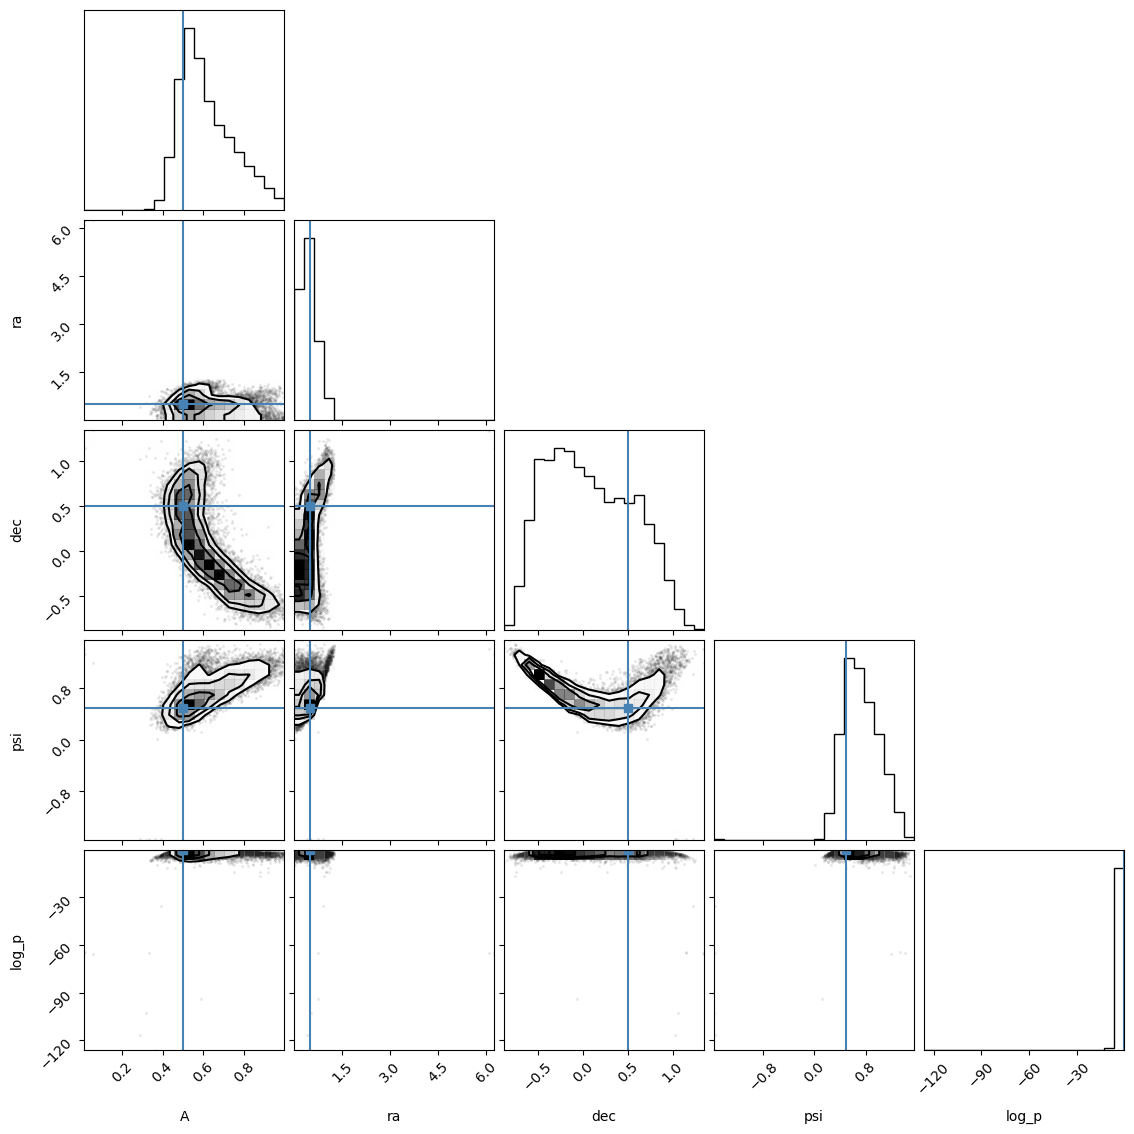

 27%|██▋       | 2400/9000 [20:11<39:57,  2.75it/s, loss=9.03]  

Epoch 2400, loss 9.031483524761862


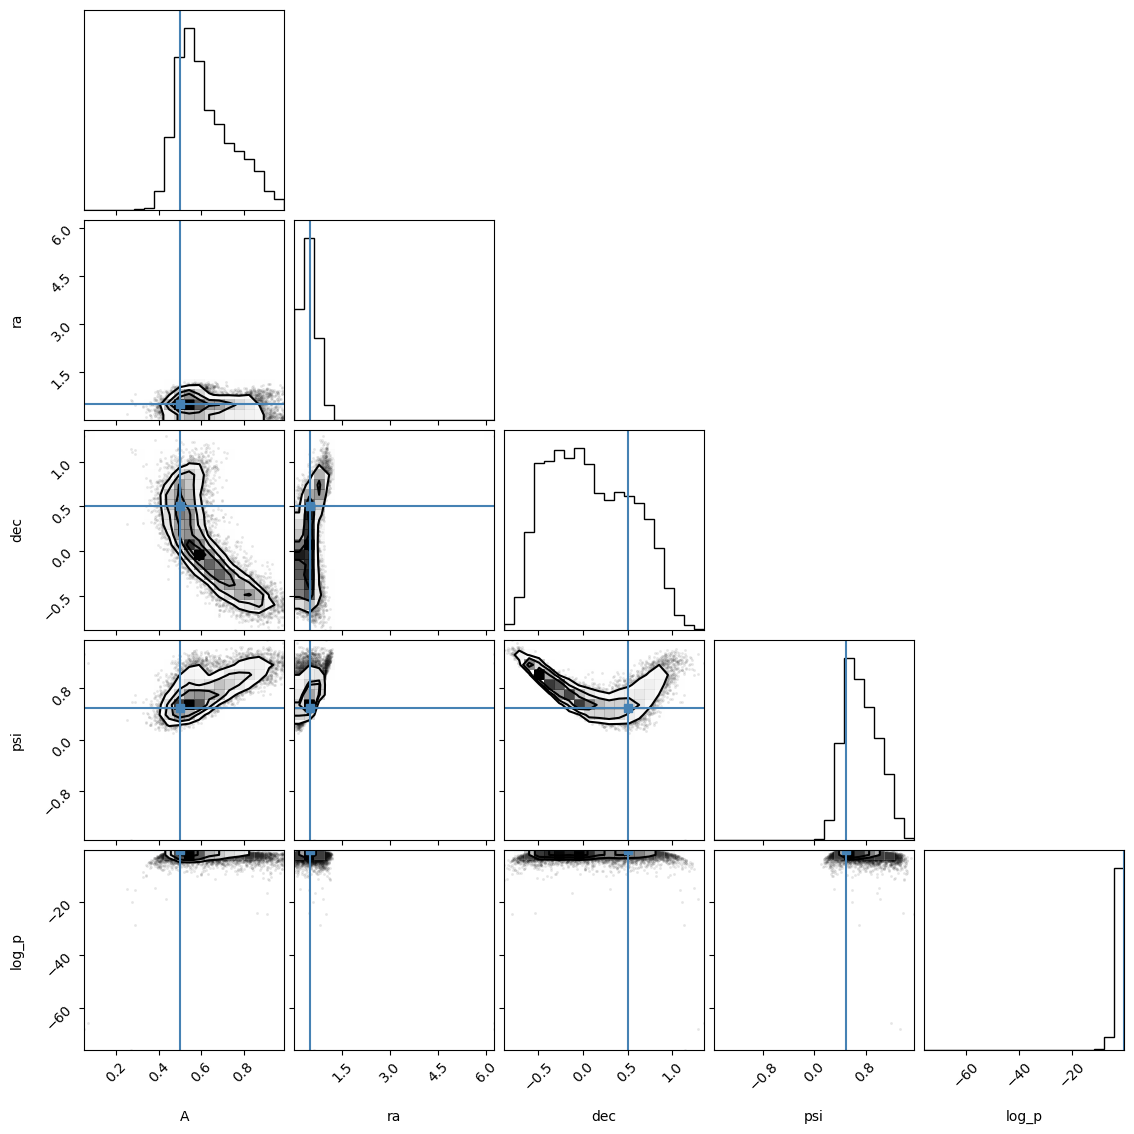

 28%|██▊       | 2500/9000 [20:48<38:46,  2.79it/s, loss=8.95]  

Epoch 2500, loss 8.953450461063323


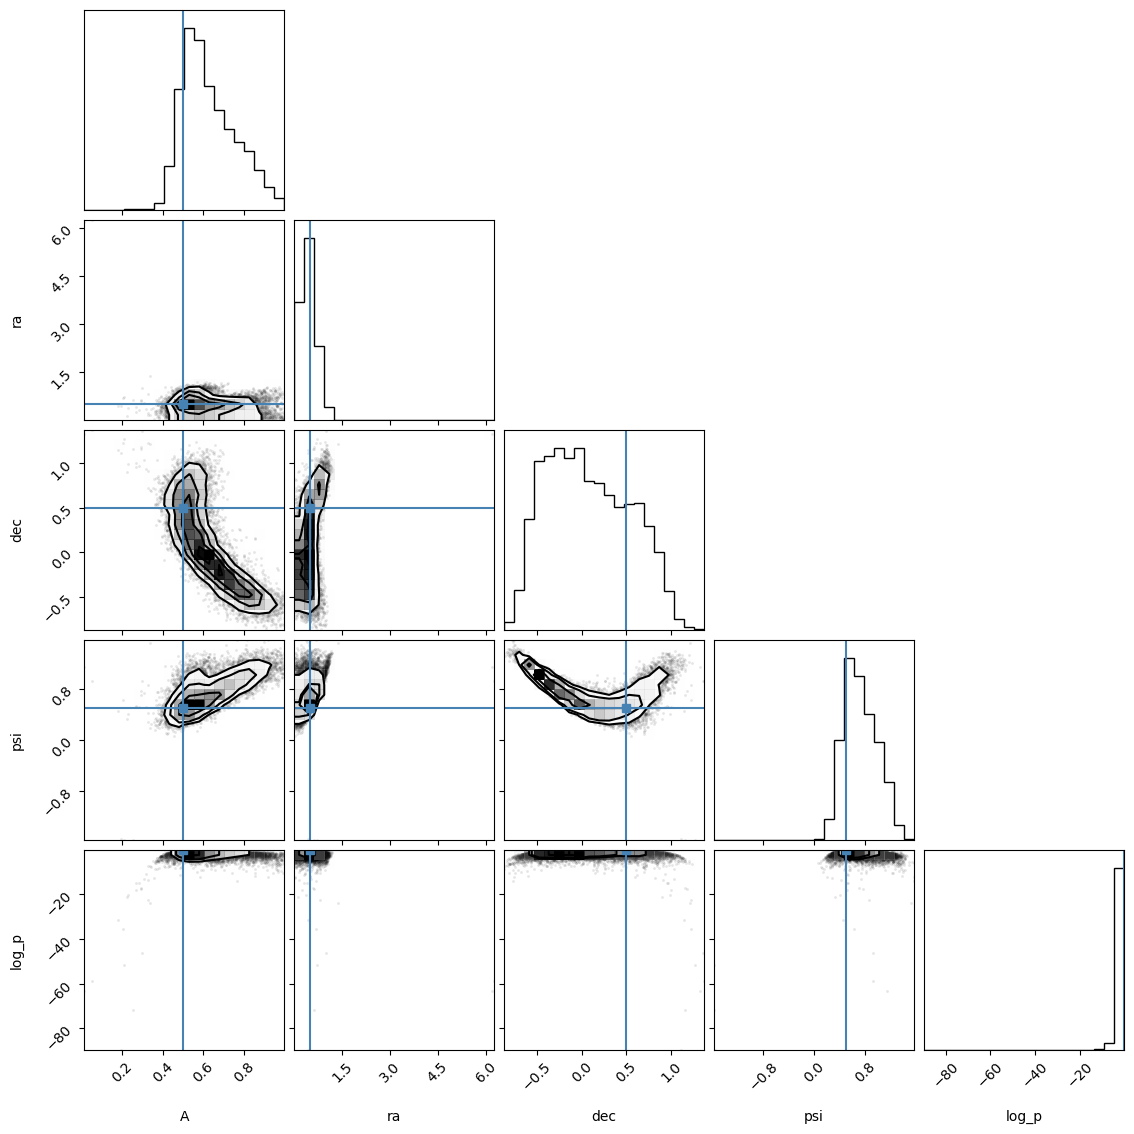

 29%|██▉       | 2600/9000 [21:25<37:08,  2.87it/s, loss=8.90]  

Epoch 2600, loss 8.900304446689766


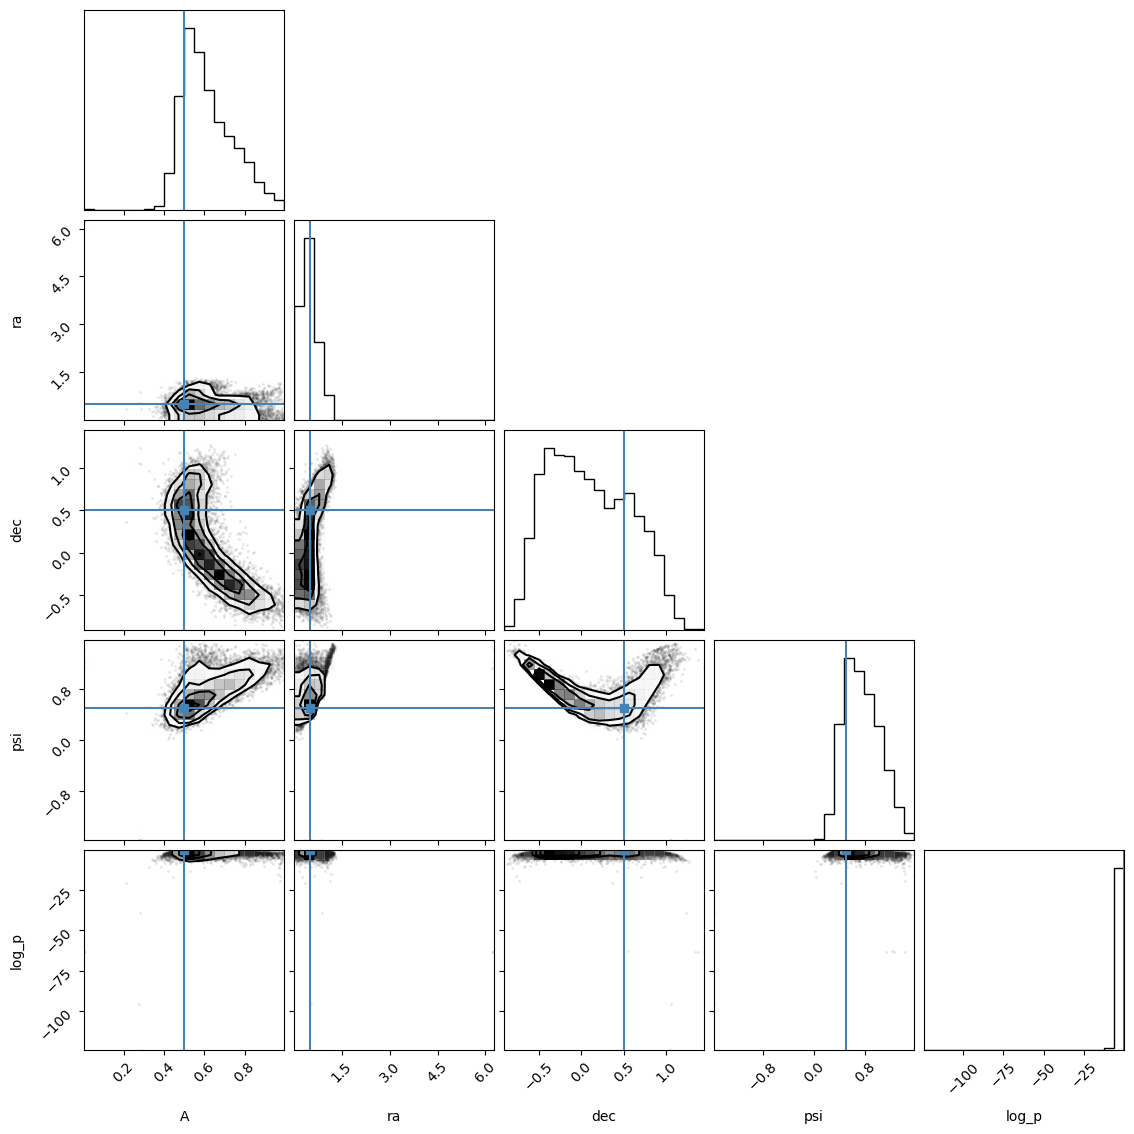

 30%|███       | 2700/9000 [22:02<36:54,  2.84it/s, loss=8.90]  

Epoch 2700, loss 8.903406751622256


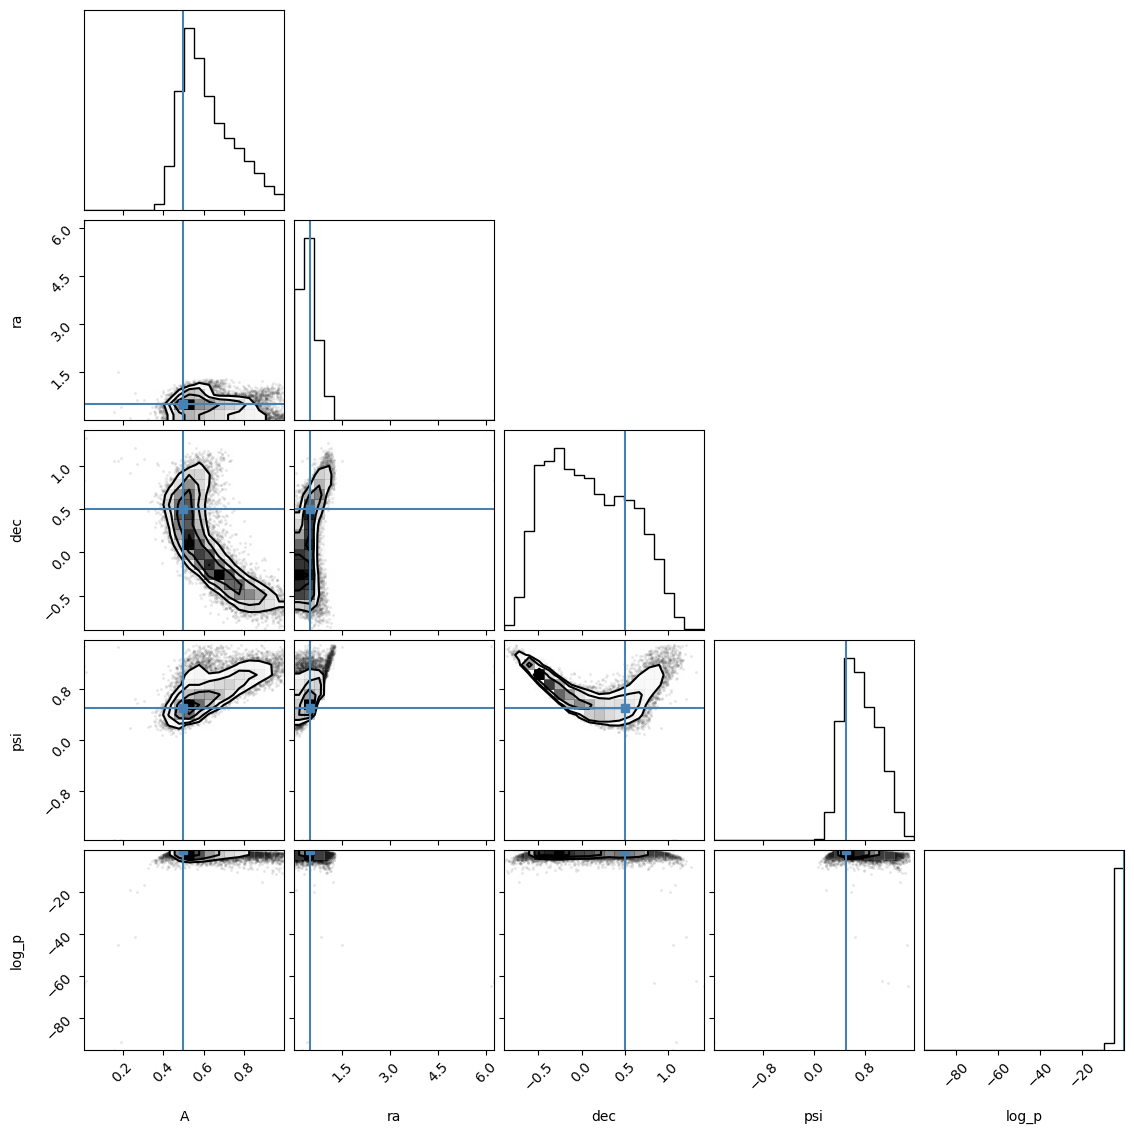

 31%|███       | 2800/9000 [22:39<36:06,  2.86it/s, loss=8.94]  

Epoch 2800, loss 8.935503430009696


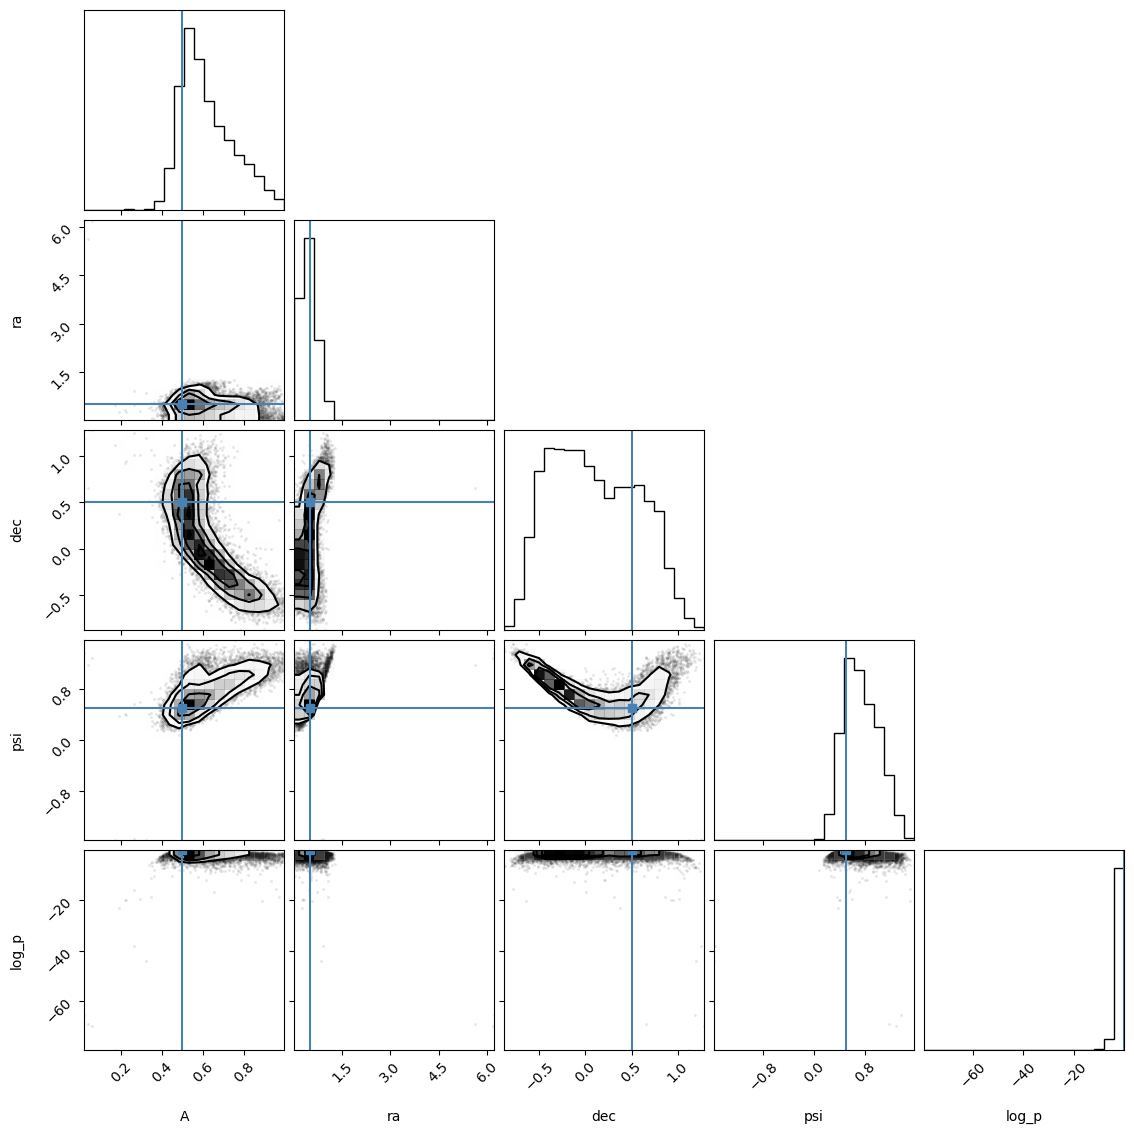

 32%|███▏      | 2900/9000 [23:16<35:09,  2.89it/s, loss=8.87]  

Epoch 2900, loss 8.867981239734943


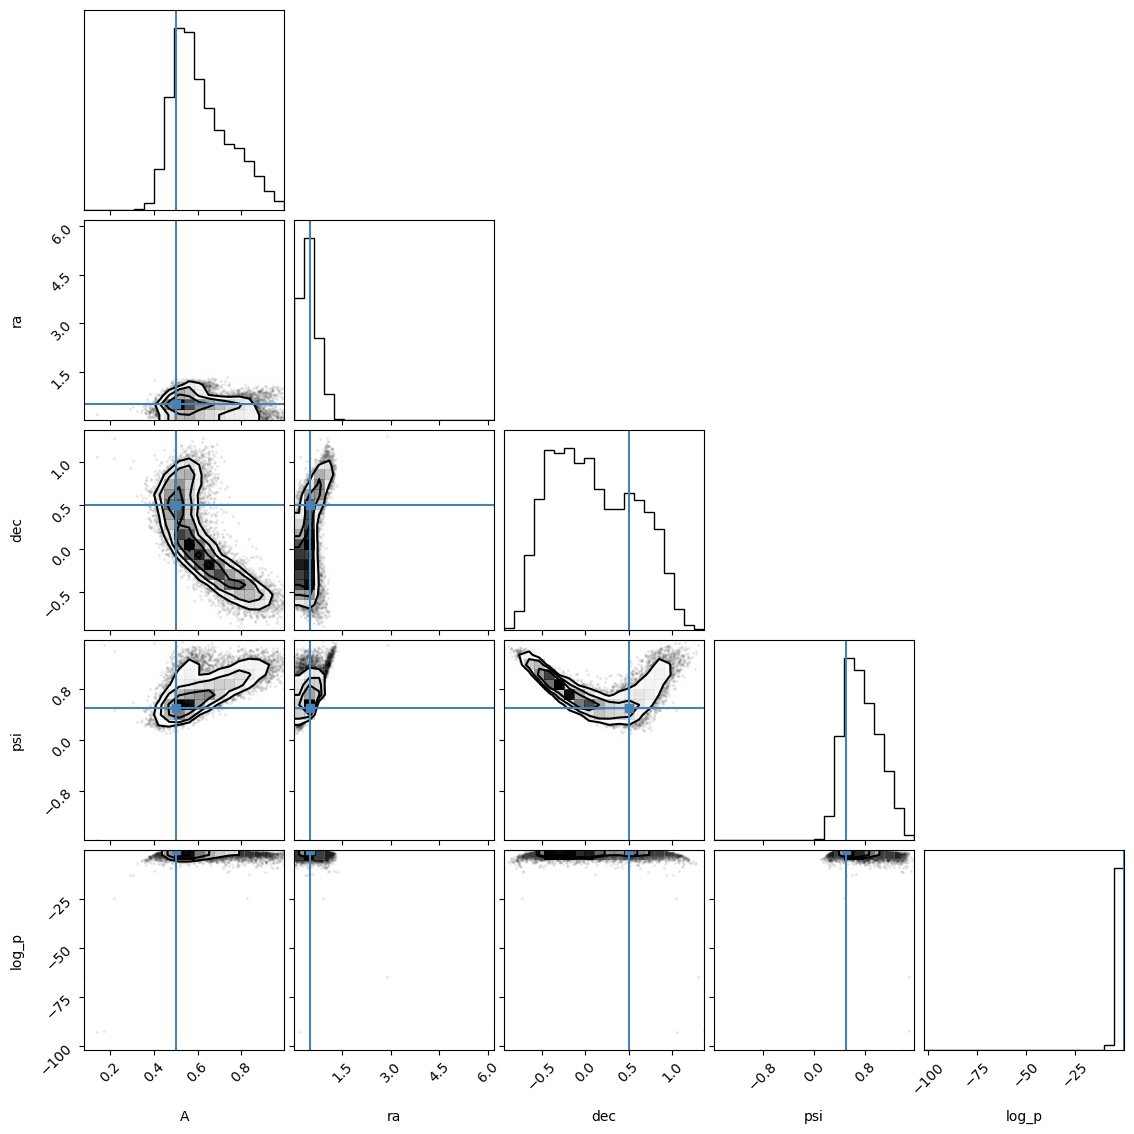

 33%|███▎      | 2974/9000 [23:43<35:56,  2.79it/s, loss=8.92]  

In [23]:

with trange(epochs) as tepochs:
    for epoch in tepochs:
  
        #update NN params (stochastic gradient descent with Adam optimiser)
        prng_key = next(prng_seq)
        loss = loss_fn(params,  prng_key, Nsamps)
        ldict['loss'] = f'{loss:.2f}'
        training_stats['loss'].append(loss)
        
        tepochs.set_postfix(ldict, refresh=True)
        params, opt_state = update(params, prng_key, opt_state)        #take a step in direction of stepest descent (negative gradient)

        #print results every 100 iterations (first one is plotted after 1st update.)
        if (epoch)%100 == 0:
            print(f'Epoch {epoch}, loss {loss}')
            x_gen, log_prob_gen = sample_and_log_prob.apply(params, next(prng_seq), 10*Nsamps)
            log_posterior = log_prob(x_gen)
            x_gen = np.array(x_gen, copy=False)
            p_gen = np.vstack(list(log_l.array_to_phys(x_gen).values()))
            data = np.concatenate([p_gen, [log_posterior]])
            fig = corner.corner(data.T, labels=['A','ra','dec','psi', 'log_p'], truths = [0.5,0.5,0.5,0.5,0.])
            pl.show()
        
        #caculate variance from stochasticity alone
        if (epoch+1)%1000 == 0:
            fixed_flow_loss = []
            for iterations in range(500):
                prng_key = next(prng_seq)
                loss = loss_fn(params,  prng_key, Nsamps)
                fixed_flow_loss.append(loss)

            fixed_flow_loss_variance = np.var(fixed_flow_loss)
            training_stats['fixed_flow_loss_variance'].append(fixed_flow_loss_variance)
            loss_variance = np.var(training_stats['loss'][-500:])
            training_stats['loss_variance'].append(loss_variance)
            print('fixed_flow_loss_variance', loss_variance)
            if loss_variance < fixed_flow_loss_variance:
                break

            #stopping criterion
            #new_mean_loss = np.mean(training_stats['loss'][-500:])
            #if np.abs(training_stats['mean_loss']-(new_mean_loss))/training_stats['mean_loss'] < 0.001:
            #    break   #break here if the training loss has decreased by less then 1% in the last 500 steps. 
            #else:
            #    training_stats['mean_loss'] = new_mean_loss
       

print("Done!")

x_gen, log_prob_gen = sample_and_log_prob.apply(params, next(prng_seq), 100*Nsamps)

x_gen = np.array(x_gen, copy=False)
p_gen = np.vstack(list(log_l.array_to_phys(x_gen).values()))
fig = corner.corner(p_gen.T, truths = truths)

pl.show()

In [19]:
fixed_flow_loss = []
with trange(100) as tepochs:
    for iter in tepochs:
  
        #update NN params (stochastic gradient descent with Adam optimiser)
        prng_key = next(prng_seq)
        loss = loss_fn(params,  prng_key, Nsamps)
        ldict['loss'] = f'{loss:.2f}'
        fixed_flow_loss.append(loss)
        
        tepochs.set_postfix(ldict, refresh=True)

100%|██████████| 100/100 [00:32<00:00,  3.12it/s, loss=9.04]


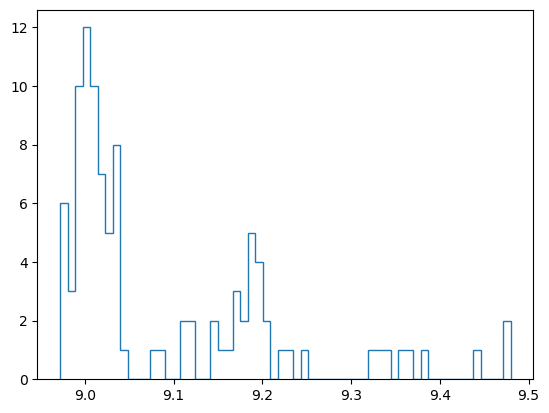

In [20]:
counts, bins = np.histogram(fixed_flow_loss, bins=60)
pl.stairs(counts, bins)

In [21]:
np.var(fixed_flow_loss)

0.015108406246210168

In [22]:
(training_stats['mean_loss']-(new_mean_loss) )/training_stats['mean_loss']

NameError: name 'new_mean_loss' is not defined

In [ ]:
training_stats['mean_loss']

8.946976680828866

In [ ]:
loss

Array(8.89508142, dtype=float64)

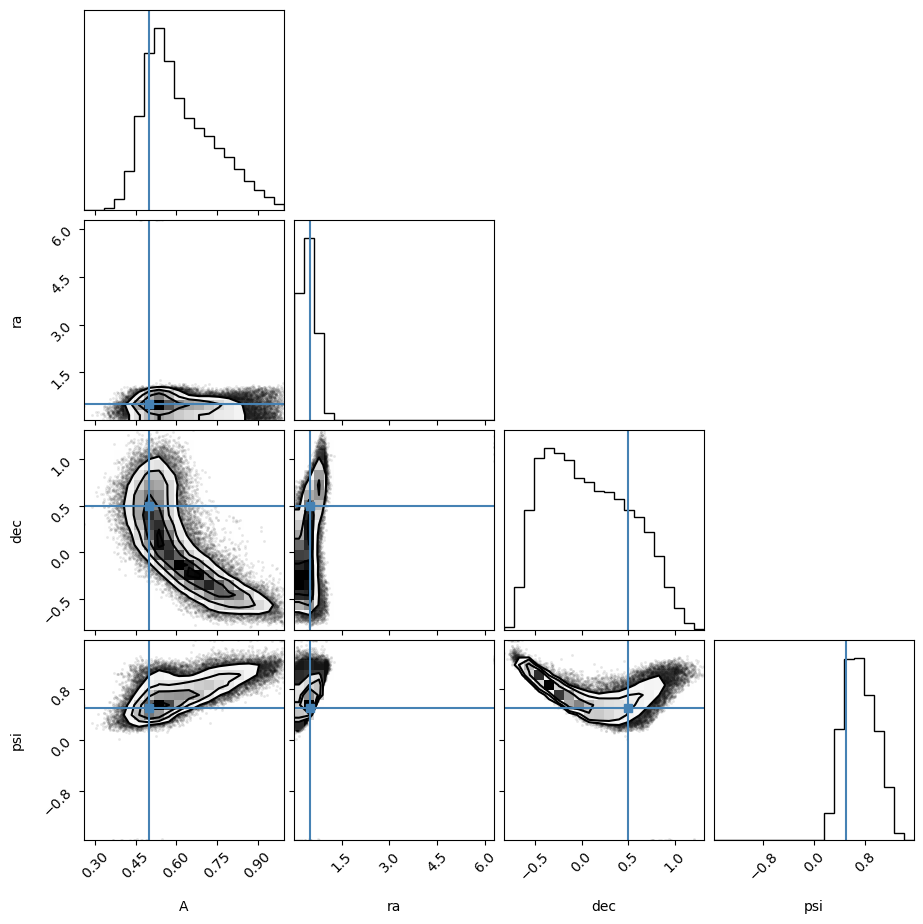

In [ ]:
x_gen, log_prob_gen = sample_and_log_prob.apply(params, next(prng_seq), 50*Nsamps)
x_gen = np.array(x_gen, copy=False)
p_gen = np.vstack(list(log_l.array_to_phys(x_gen).values()))
fig = corner.corner(p_gen.T, labels=log_l.params, truths = truths)

Text(0, 0.5, 'Log(loss)')

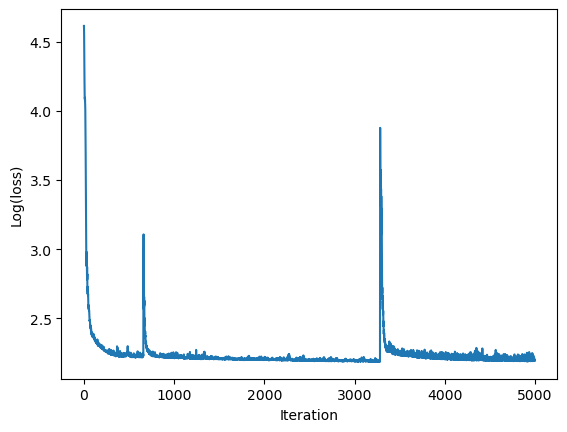

In [ ]:
L=training_stats['loss'][:]


#pl.plot(np.arange(4000, 6000, 1), L[4000:])
pl.plot(np.log(L[:]))
pl.xlabel("Iteration")
pl.ylabel("Log(loss)")


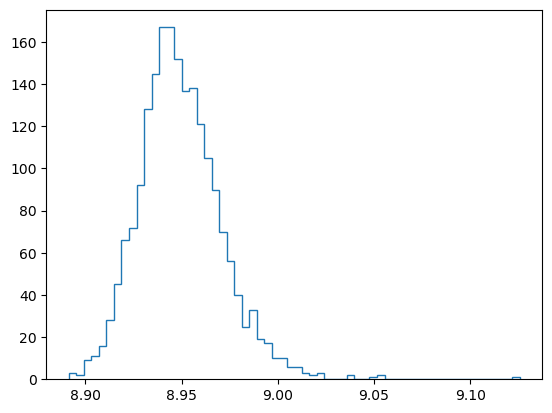

In [ ]:
counts, bins = np.histogram(L, bins=60)
pl.stairs(counts, bins)

In [ ]:
np.sqrt(np.var(L))/np.mean(L)

0.002393273563871293

In [ ]:
#from jax.test_util import check_grads
#check_grads(loss_fn, params, order=2)  # check up to 2nd order derivatives

In [ ]:
jax.grad(logl)(true_params)

NameError: name 'logl' is not defined

In [ ]:
true_params = dict(A=0.5,t0=0.5,
        f0=20.,
        tau=1/10,
        ra=jnp.atleast_1d(0.5),
        dec=jnp.atleast_1d(0.5),
        psi=jnp.atleast_1d(0.5))

In [ ]:
def logl(params):
    return log_l(params)[0]

In [ ]:
def logl(x):
    p = dict()
    p['A'] = x[0]
    p['ra'] = jnp.atleast_1d(x[1])
    p['dec'] = jnp.atleast_1d(x[2]) 
    p['psi'] = jnp.atleast_1d(x[3]) 

    return log_l(p)[0]

In [ ]:
def logprior(theta,theta_min,theta_max):       # pass the parameter location and the parameter bounds
    if np.any(theta-theta_max>0) or np.any(theta_min-theta>0):
        return -np.inf     # if outside the bounds return probability = 0 (log-prob = -infinity)
    dec = theta[2]
    return np.log(np.cos(dec))             # otherwise just return logprob = 0.0

In [ ]:
x = np.array([0.5,0.5,0.5,0.5])
x_min = np.array([0.,0.,-np.pi/2.,-np.pi/2.])
x_max = np.array([1.,2*np.pi,np.pi/2.,np.pi/2.])

In [ ]:
def logprob(x, x_min, x_max):
    return logl(x)+logprior(x, x_min, x_max)

In [ ]:
import emcee

In [ ]:
nwalkers = 32
ndim=4
p0 = np.random.rand(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, logprob, args=(x_min, x_max))

In [ ]:
state = sampler.run_mcmc(p0, 500)
sampler.reset()

In [ ]:
sampler.run_mcmc(state, 10000)

In [ ]:
#f = open('samples_emcee_cosprior.npy', 'wb')
#np.save(f,samples)
f = open('samples_emcee_cosprior.npy', 'rb')
samples = np.load(f)

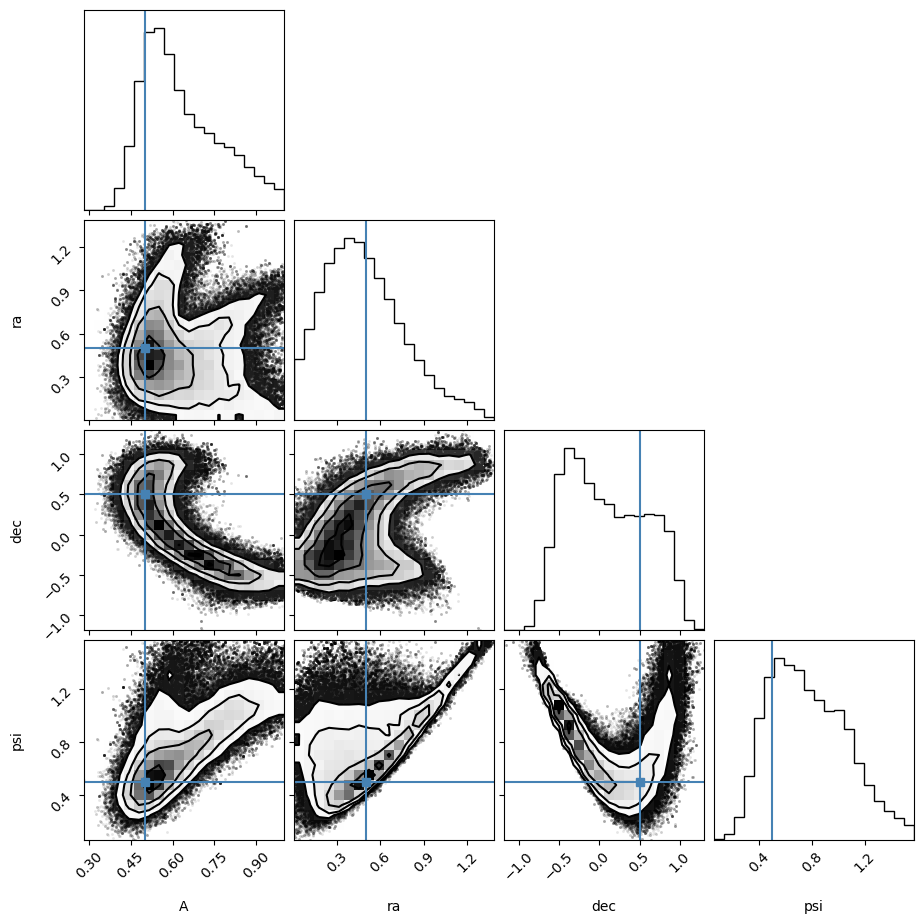

In [ ]:
#samples = sampler.get_chain(flat=True)
fig = corner.corner(samples, labels=log_l.params, truths = truths)
pl.show()

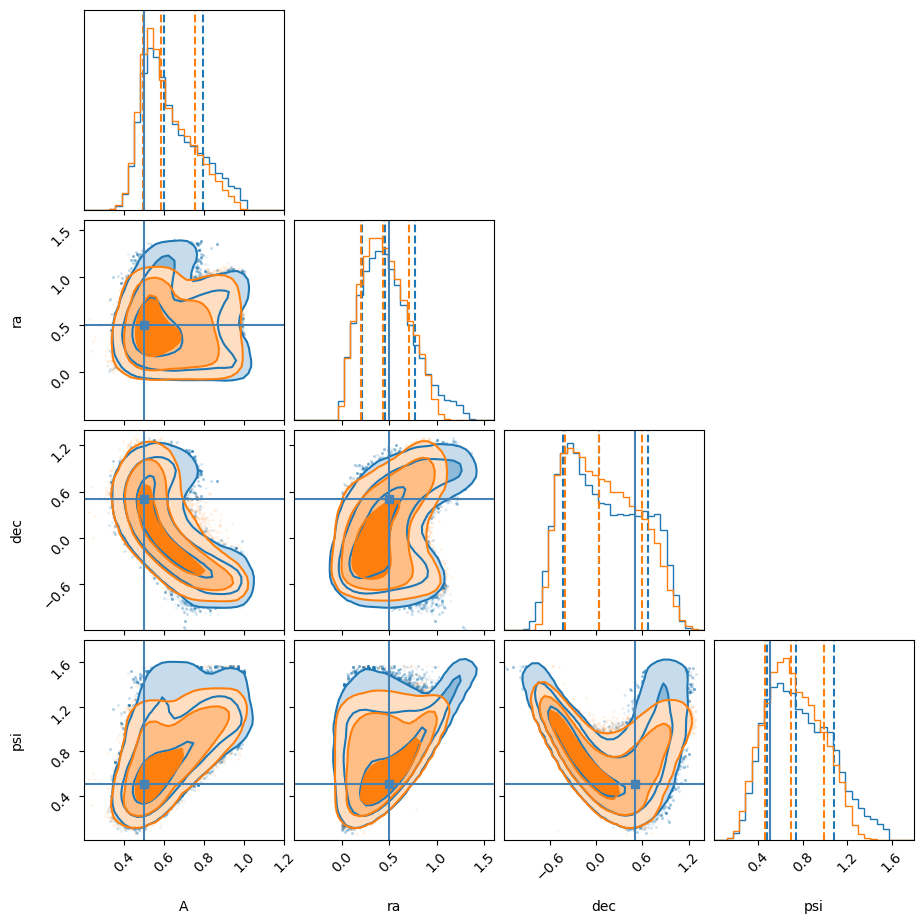

In [ ]:
#n = 10_000
#dims = 2

#x1 = np.random.randn(n, dims) - 1
#x2 = np.random.randn(n, dims) + 1

kwargs = dict(
    bins=32,
    smooth=0.9,
    quantiles=[0.16, 0.5, 0.84],
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.0)),
    plot_density=True,
    plot_datapoints=True,
    fill_contours=True,
    show_titles=False,
    hist_kwargs=dict(density=True),
    range = [(0.2,1.2), (-0.5,1.6),(-1.2,1.4), (0,1.8), ]
)

fig = None

# Need to update colours for 1D and 2D plots
kwargs["color"] = "C0"
kwargs["hist_kwargs"]["color"] = "C0"
fig = corner.corner(samples, fig=fig, **kwargs)

kwargs["color"] = "C1"
kwargs["hist_kwargs"]["color"] = "C1"
fig = corner.corner(p_gen.T, labels=log_l.params, truths = truths, fig=fig, **kwargs)


#fig.savefig("corner_comparison.png")
pl.show()